# MODELOS 

In [ ]:
import pandas as pd
from IPython.display import display

# Ruta al archivo CSV
file_path = r'C:\Users\USUARIO\Desktop\nuevo\BDFINAL.csv'

# Cargar el archivo CSV en un DataFrame, usando low_memory=False
df = pd.read_csv(file_path, low_memory=False)

# Mostrar las primeras filas del DataFrame con un formato agradable
display(df.head())

# ENFOQUE BASADO EN LOGBB

Total de variables numéricas: 616

Distribución original de clases:
logBB
0    53.0
1    47.0
Name: proportion, dtype: float64 %

Distribución después de Random Undersampling:
logBB
0    50.0
1    50.0
Name: proportion, dtype: float64 %

Optimizando hiperparámetros usando RandomizedSearchCV...
Probando 100 combinaciones diferentes con 5-fold CV
Fitting 5 folds for each of 100 candidates, totalling 500 fits

Mejores parámetros encontrados:
bootstrap: False
class_weight: balanced
criterion: entropy
max_depth: None
max_features: sqrt
min_samples_leaf: 3
min_samples_split: 5
n_estimators: 646

Mejor puntuación F1: 0.815

Top 5 mejores combinaciones:

Combinación 45
F1-score medio: 0.815
bootstrap: False
class_weight: balanced
criterion: entropy
max_depth: None
max_features: sqrt
min_samples_leaf: 3
min_samples_split: 5
n_estimators: 646

Combinación 68
F1-score medio: 0.812
bootstrap: False
class_weight: balanced
criterion: entropy
max_depth: 70
max_features: log2
min_samples_leaf: 3
min_s

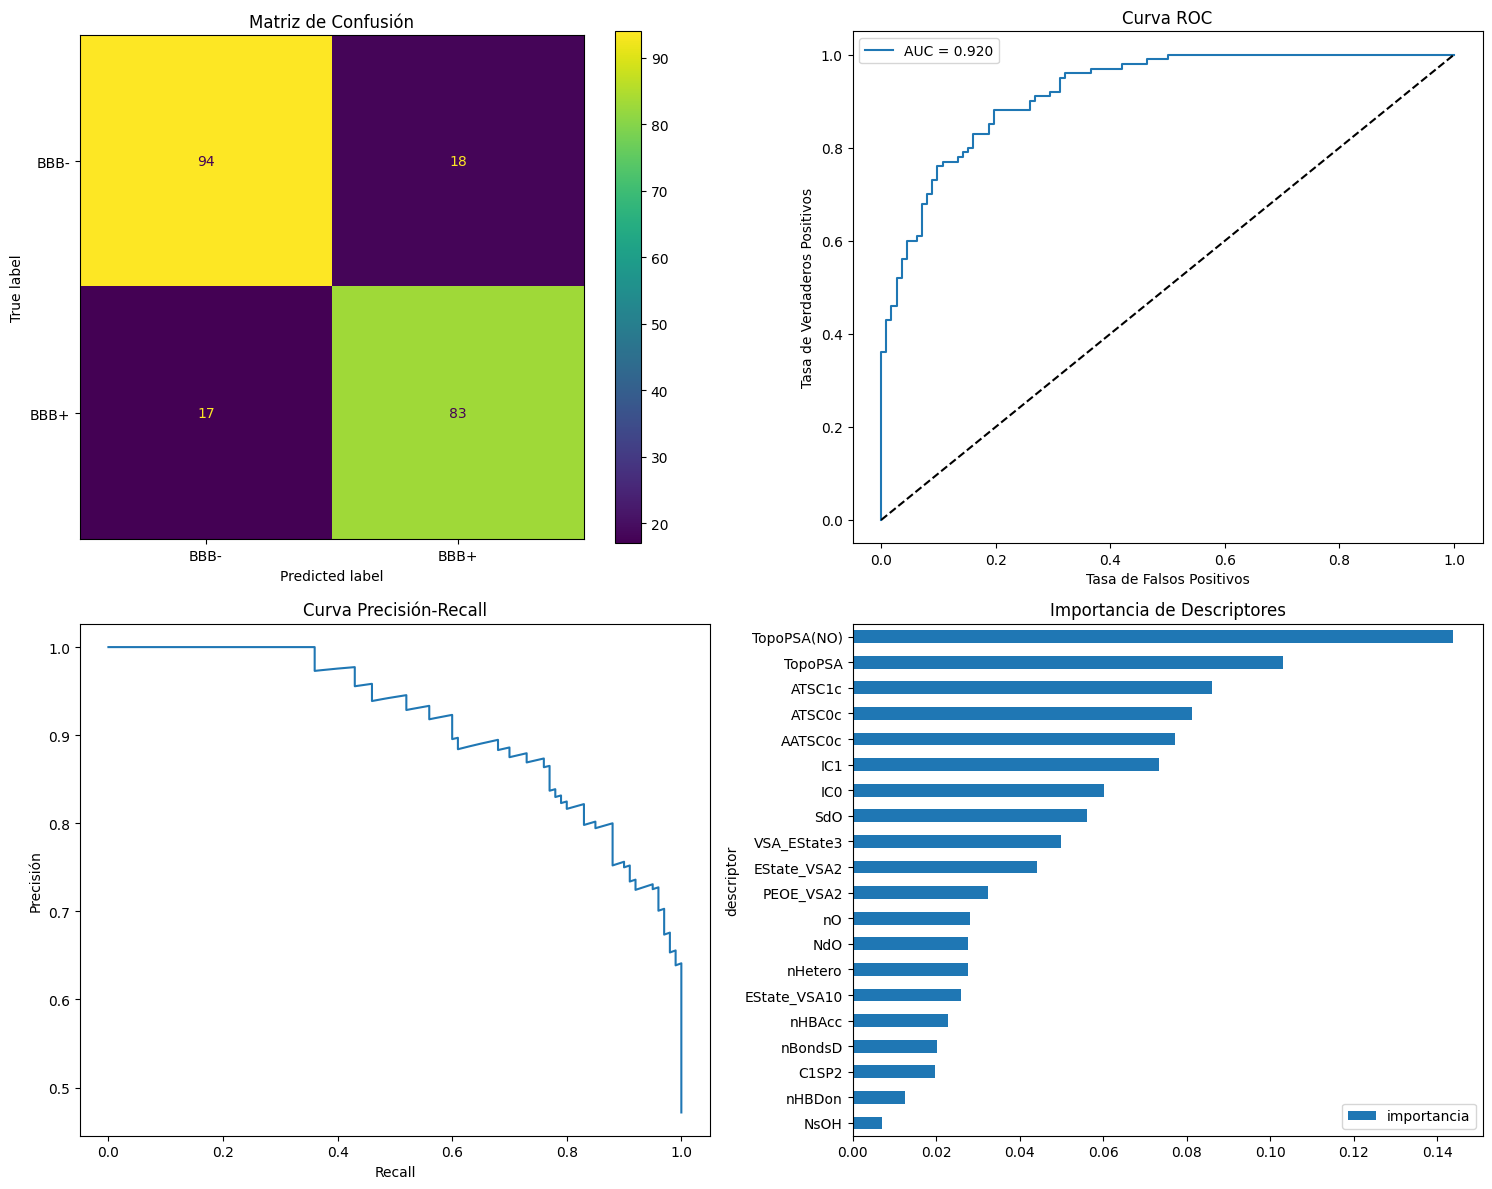

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, confusion_matrix, ConfusionMatrixDisplay, 
                           classification_report, roc_curve, precision_recall_curve, 
                           auc, roc_auc_score)
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler
from scipy.stats import randint, uniform

# Cargar datos
file_path = r'C:\Users\USUARIO\Desktop\nuevo\BDFINAL.csv'
df = pd.read_csv(file_path, low_memory=False)

class PreparacionBHE:
    def __init__(self, df):
        self.df = df.select_dtypes(include=[np.number])
        self.scaler = StandardScaler()
        print(f"Total de variables numéricas: {len(self.df.columns)}")
    
    def seleccionar_descriptores_relevantes(self, k=20):
        if 'logBB' not in self.df.columns:
            raise ValueError("'logBB' no está en el DataFrame.")
        
        X = self.df.drop(columns='logBB', errors='ignore')
        y = self.df['logBB'].dropna()
        X = X.loc[y.index]
        
        selector = SelectKBest(score_func=f_regression, k=k)
        selector.fit(X, y)
        
        return X.columns[selector.get_support()].tolist()
    
    def preparar_datos_modelo(self):
        descriptores = self.seleccionar_descriptores_relevantes()
        
        X = self.df[descriptores]
        y = self.df['logBB']
        
        datos_completos = pd.concat([X, y], axis=1).dropna()
        X = datos_completos[descriptores]
        y = datos_completos['logBB']
        
        X_scaled = self.scaler.fit_transform(X)
        X_scaled = pd.DataFrame(X_scaled, columns=descriptores)
        
        # Usar umbral 0 para clasificación
        y_clases = (y > 0).astype(int)
        
        print("\nDistribución original de clases:")
        print(pd.Series(y_clases).value_counts(normalize=True).round(3) * 100, "%")
        
        # Dividir datos
        X_train, X_test, y_train, y_test = train_test_split(
            X_scaled, y_clases, test_size=0.2, random_state=42, stratify=y_clases
        )
        
        # Aplicar Random Undersampling
        rus = RandomUnderSampler(random_state=42)
        X_train_bal, y_train_bal = rus.fit_resample(X_train, y_train)
        
        print("\nDistribución después de Random Undersampling:")
        print(pd.Series(y_train_bal).value_counts(normalize=True).round(3) * 100, "%")
        
        return X_train_bal, X_test, y_train_bal, y_test, descriptores
    
    def optimizar_hiperparametros(self, X_train, y_train):
        # Definir espacio de búsqueda
        param_distributions = {
            'n_estimators': randint(100, 1000),
            'max_depth': [None] + list(range(10, 110, 10)),
            'min_samples_split': randint(2, 20),
            'min_samples_leaf': randint(1, 10),
            'max_features': ['sqrt', 'log2', None],
            'bootstrap': [True, False],
            'criterion': ['gini', 'entropy'],
            'class_weight': ['balanced', 'balanced_subsample']
        }
        
        rf = RandomForestClassifier(random_state=42)
        
        random_search = RandomizedSearchCV(
            estimator=rf,
            param_distributions=param_distributions,
            n_iter=100,  # Número de combinaciones a probar
            scoring='f1',
            cv=5,
            verbose=1,
            n_jobs=-1,
            random_state=42
        )
        
        print("\nOptimizando hiperparámetros usando RandomizedSearchCV...")
        print(f"Probando 100 combinaciones diferentes con 5-fold CV")
        
        random_search.fit(X_train, y_train)
        
        print("\nMejores parámetros encontrados:")
        for param, value in random_search.best_params_.items():
            print(f"{param}: {value}")
        
        print(f"\nMejor puntuación F1: {random_search.best_score_:.3f}")
        
        # Mostrar top 5 mejores combinaciones
        resultados = pd.DataFrame(random_search.cv_results_)
        top_5 = resultados.sort_values('mean_test_score', ascending=False).head()
        
        print("\nTop 5 mejores combinaciones:")
        for idx, row in top_5.iterrows():
            print(f"\nCombinación {idx + 1}")
            print(f"F1-score medio: {row['mean_test_score']:.3f}")
            params = row['params']
            for param, value in params.items():
                print(f"{param}: {value}")
        
        return random_search.best_estimator_
    
    def plot_curvas_evaluacion(self, y_test, y_pred, y_prob, titulo=""):
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
        
        # Matriz de confusión
        cm = confusion_matrix(y_test, y_pred)
        ConfusionMatrixDisplay(
            confusion_matrix=cm, 
            display_labels=['BBB-', 'BBB+']
        ).plot(ax=ax1)
        ax1.set_title('Matriz de Confusión')
        
        # Curva ROC
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        ax2.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
        ax2.plot([0, 1], [0, 1], 'k--')
        ax2.set_xlabel('Tasa de Falsos Positivos')
        ax2.set_ylabel('Tasa de Verdaderos Positivos')
        ax2.set_title('Curva ROC')
        ax2.legend()
        
        # Curva Precisión-Recall
        precision, recall, _ = precision_recall_curve(y_test, y_prob)
        ax3.plot(recall, precision)
        ax3.set_xlabel('Recall')
        ax3.set_ylabel('Precisión')
        ax3.set_title('Curva Precisión-Recall')
        
        # Importancia de características
        importancia = pd.DataFrame({
            'descriptor': self.current_descriptors,
            'importancia': self.current_model.feature_importances_
        }).sort_values('importancia', ascending=True)
        
        importancia.plot(kind='barh', x='descriptor', y='importancia', ax=ax4)
        ax4.set_title('Importancia de Descriptores')
        
        plt.tight_layout()
        plt.show()
    
    def entrenar_modelo(self):
        X_train, X_test, y_train, y_test, descriptores = self.preparar_datos_modelo()
        
        # Optimizar hiperparámetros
        modelo = self.optimizar_hiperparametros(X_train, y_train)
        
        # Entrenar modelo con mejores parámetros
        modelo.fit(X_train, y_train)
        
        # Guardar para visualización
        self.current_model = modelo
        self.current_descriptors = descriptores
        
        # Predicciones
        y_pred = modelo.predict(X_test)
        y_prob = modelo.predict_proba(X_test)[:, 1]
        
        # Métricas
        accuracy = accuracy_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_prob)
        
        print("\nResultados del modelo:")
        print("-" * 50)
        print(f"Accuracy: {accuracy:.3f}")
        print(f"ROC AUC: {roc_auc:.3f}")
        print("\nReporte de clasificación:")
        print(classification_report(y_test, y_pred))
        
        # Visualizar resultados
        self.plot_curvas_evaluacion(y_test, y_pred, y_prob)
        
        return modelo, (X_test, y_test, y_pred, y_prob)

# Ejecutar análisis
modelo_bhe = PreparacionBHE(df)
modelo, resultados = modelo_bhe.entrenar_modelo()


Total de variables numéricas: 616
Se usarán todas las variables excepto logBB como predictores

Dimensiones del dataset:
Número de muestras: 1058
Número de variables: 615

Distribución original de clases:
BBB- (clase 0): 561 moléculas
BBB+ (clase 1): 497 moléculas

Porcentajes:
logBB
0    53.0
1    47.0
Name: proportion, dtype: float64 %

Distribución después de Random Undersampling:
BBB- (clase 0): 397 moléculas
BBB+ (clase 1): 397 moléculas

Optimizando hiperparámetros con RandomizedSearchCV...
Probando 100 combinaciones diferentes
Fitting 5 folds for each of 100 candidates, totalling 500 fits

Mejores parámetros encontrados:
bootstrap: False
class_weight: balanced_subsample
criterion: entropy
max_depth: 20
max_features: sqrt
min_samples_leaf: 7
min_samples_split: 5
n_estimators: 388

Mejor puntuación F1: 0.821

Top 5 mejores combinaciones:

Combinación 64
F1-score medio: 0.821
bootstrap: False
class_weight: balanced_subsample
criterion: entropy
max_depth: 20
max_features: sqrt
min_

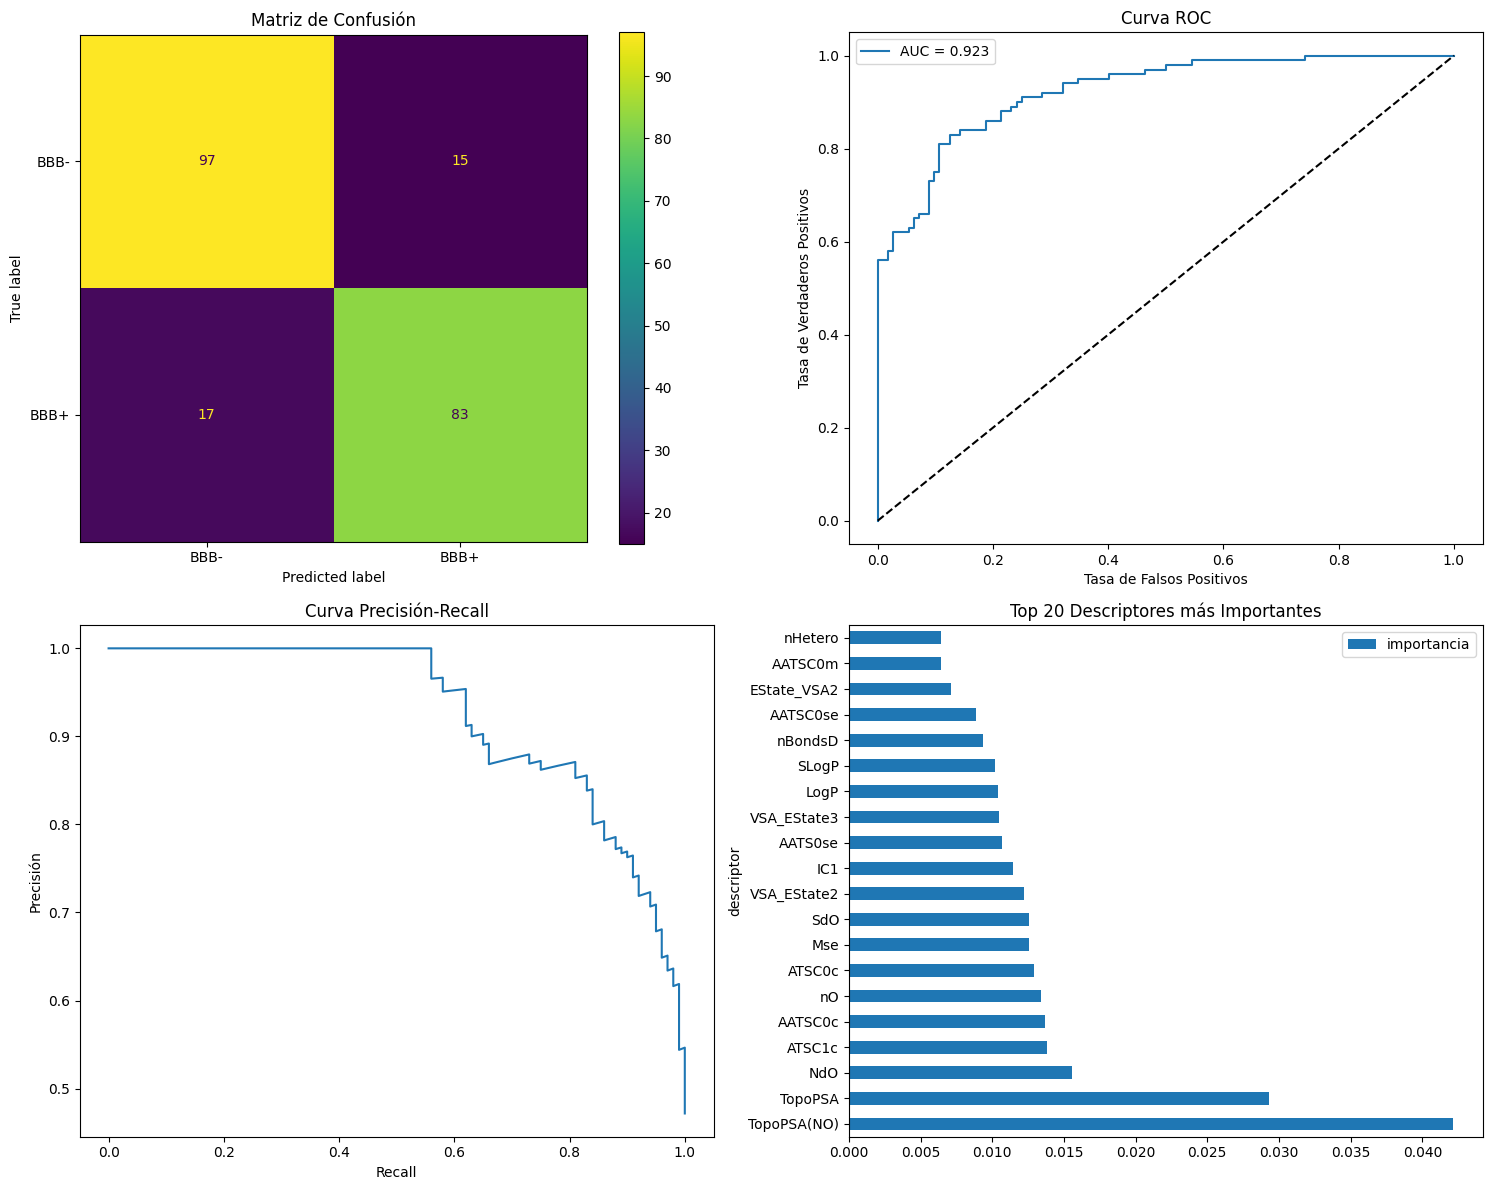


Top 20 descriptores más importantes guardados en 'top_descriptores.csv'


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, confusion_matrix, ConfusionMatrixDisplay, 
                           classification_report, roc_curve, precision_recall_curve, 
                           auc, roc_auc_score)
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler
from scipy.stats import randint, uniform

# Cargar datos
file_path = r'C:\Users\USUARIO\Desktop\nuevo\BDFINAL.csv'
df = pd.read_csv(file_path, low_memory=False)

class PreparacionBHE:
    def __init__(self, df):
        self.df = df.select_dtypes(include=[np.number])
        self.scaler = StandardScaler()
        print(f"\nTotal de variables numéricas: {len(self.df.columns)}")
        print("Se usarán todas las variables excepto logBB como predictores")
    
    def preparar_datos_modelo(self):
        # Usar todas las variables excepto logBB
        X = self.df.drop(columns='logBB', errors='ignore')
        y = self.df['logBB']
        
        # Eliminar filas con valores nulos
        datos_completos = pd.concat([X, y], axis=1).dropna()
        X = datos_completos.drop(columns='logBB')
        y = datos_completos['logBB']
        
        print(f"\nDimensiones del dataset:")
        print(f"Número de muestras: {len(X)}")
        print(f"Número de variables: {len(X.columns)}")
        
        # Escalar características
        X_scaled = self.scaler.fit_transform(X)
        X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
        
        # Usar umbral 0 para clasificación
        y_clases = (y > 0).astype(int)
        
        print("\nDistribución original de clases:")
        clase_counts = y_clases.value_counts()
        print(f"BBB- (clase 0): {clase_counts[0]} moléculas")
        print(f"BBB+ (clase 1): {clase_counts[1]} moléculas")
        print("\nPorcentajes:")
        print(pd.Series(y_clases).value_counts(normalize=True).round(3) * 100, "%")
        
        # Dividir datos
        X_train, X_test, y_train, y_test = train_test_split(
            X_scaled, y_clases, test_size=0.2, random_state=42, stratify=y_clases
        )
        
        # Aplicar Random Undersampling
        rus = RandomUnderSampler(random_state=42)
        X_train_bal, y_train_bal = rus.fit_resample(X_train, y_train)
        
        print("\nDistribución después de Random Undersampling:")
        clase_counts_bal = pd.Series(y_train_bal).value_counts()
        print(f"BBB- (clase 0): {clase_counts_bal[0]} moléculas")
        print(f"BBB+ (clase 1): {clase_counts_bal[1]} moléculas")
        
        return X_train_bal, X_test, y_train_bal, y_test, X.columns
    
    def optimizar_hiperparametros(self, X_train, y_train):
        # Espacio de búsqueda para RandomizedSearchCV
        param_distributions = {
            'n_estimators': randint(100, 1000),
            'max_depth': [10, 20, 30, 40, 50, None],
            'min_samples_split': randint(2, 20),
            'min_samples_leaf': randint(1, 10),
            'max_features': ['sqrt', 'log2', None],
            'bootstrap': [True, False],
            'criterion': ['gini', 'entropy'],
            'class_weight': ['balanced', 'balanced_subsample']
        }
        
        rf = RandomForestClassifier(random_state=42)
        
        random_search = RandomizedSearchCV(
            estimator=rf,
            param_distributions=param_distributions,
            n_iter=100,  # Número de combinaciones a probar
            cv=5,
            scoring='f1',
            n_jobs=-1,
            verbose=1,
            random_state=42
        )
        
        print("\nOptimizando hiperparámetros con RandomizedSearchCV...")
        print("Probando 100 combinaciones diferentes")
        
        random_search.fit(X_train, y_train)
        
        print("\nMejores parámetros encontrados:")
        for param, value in random_search.best_params_.items():
            print(f"{param}: {value}")
        
        print(f"\nMejor puntuación F1: {random_search.best_score_:.3f}")
        
        # Mostrar las 5 mejores combinaciones
        resultados = pd.DataFrame(random_search.cv_results_)
        top_5 = resultados.sort_values('mean_test_score', ascending=False).head()
        
        print("\nTop 5 mejores combinaciones:")
        for idx, row in top_5.iterrows():
            print(f"\nCombinación {idx + 1}")
            print(f"F1-score medio: {row['mean_test_score']:.3f}")
            params = row['params']
            for param, value in params.items():
                print(f"{param}: {value}")
        
        return random_search.best_estimator_
    
    def plot_curvas_evaluacion(self, y_test, y_pred, y_prob, importancia):
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
        
        # Matriz de confusión
        cm = confusion_matrix(y_test, y_pred)
        ConfusionMatrixDisplay(
            confusion_matrix=cm, 
            display_labels=['BBB-', 'BBB+']
        ).plot(ax=ax1)
        ax1.set_title('Matriz de Confusión')
        
        # Curva ROC
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        ax2.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
        ax2.plot([0, 1], [0, 1], 'k--')
        ax2.set_xlabel('Tasa de Falsos Positivos')
        ax2.set_ylabel('Tasa de Verdaderos Positivos')
        ax2.set_title('Curva ROC')
        ax2.legend()
        
        # Curva Precisión-Recall
        precision, recall, _ = precision_recall_curve(y_test, y_prob)
        ax3.plot(recall, precision)
        ax3.set_xlabel('Recall')
        ax3.set_ylabel('Precisión')
        ax3.set_title('Curva Precisión-Recall')
        
        # Top 20 descriptores más importantes
        importancia.head(20).plot(kind='barh', x='descriptor', y='importancia', ax=ax4)
        ax4.set_title('Top 20 Descriptores más Importantes')
        
        plt.tight_layout()
        plt.show()
        
        # Guardar los 20 descriptores más importantes
        print("\nTop 20 descriptores más importantes guardados en 'top_descriptores.csv'")
        importancia.head(20).to_csv('top_descriptores.csv', index=False)
    
    def entrenar_modelo(self):
        X_train, X_test, y_train, y_test, descriptores = self.preparar_datos_modelo()
        
        # Optimizar hiperparámetros
        modelo = self.optimizar_hiperparametros(X_train, y_train)
        
        # Entrenar modelo con mejores parámetros
        modelo.fit(X_train, y_train)
        
        # Predicciones
        y_pred = modelo.predict(X_test)
        y_prob = modelo.predict_proba(X_test)[:, 1]
        
        # Calcular importancia de características
        importancia = pd.DataFrame({
            'descriptor': descriptores,
            'importancia': modelo.feature_importances_
        }).sort_values('importancia', ascending=False)
        
        # Métricas
        accuracy = accuracy_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_prob)
        
        print("\nResultados del modelo:")
        print("-" * 50)
        print(f"Accuracy: {accuracy:.3f}")
        print(f"ROC AUC: {roc_auc:.3f}")
        print("\nReporte de clasificación:")
        print(classification_report(y_test, y_pred))
        
        # Visualizar resultados
        self.plot_curvas_evaluacion(y_test, y_pred, y_prob, importancia)
        
        return modelo, importancia, (X_test, y_test, y_pred, y_prob)

# Ejecutar análisis
modelo_bhe = PreparacionBHE(df)
modelo, importancia, resultados = modelo_bhe.entrenar_modelo()

## Modelo enfoque LogP


El presente estudio implementa un Random Forest Classifier para predecir la variable objetivo LogP, que indica la lipofilia de compuestos químicos, utilizando descriptores numéricos como variables predictivas. Se inicia con la carga y preparación de datos, donde se eliminan columnas con valores nulos y se seleccionan las características más relevantes mediante el método de selección univariada. Posteriormente, los datos se normalizan y se dividen en conjuntos de entrenamiento y prueba, aplicando técnicas de submuestreo para equilibrar las clases. Se optimizan los hiperparámetros del modelo mediante RandomizedSearchCV, lo que permite encontrar la mejor configuración para maximizar la puntuación F1. Finalmente, se evalúa el rendimiento del modelo a través de métricas como precisión, ROC AUC y se visualizan los resultados mediante curvas de evaluación y la importancia de los descriptores, proporcionando así una comprensión integral de la capacidad predictiva del modelo en relación con la barrera hematoencefálica.

Total de variables predictoras numéricas: 615
Variables predictoras después de eliminar columnas con nulos: 614

Distribución original de clases:
LogP
1    88.4
0    11.6
Name: proportion, dtype: float64 %

Distribución después de Random Undersampling:
LogP
0    50.0
1    50.0
Name: proportion, dtype: float64 %

Optimizando hiperparámetros usando RandomizedSearchCV...
Probando 100 combinaciones diferentes con 5-fold CV
Fitting 5 folds for each of 100 candidates, totalling 500 fits

Mejores parámetros encontrados:
bootstrap: False
class_weight: balanced
criterion: entropy
max_depth: 90
max_features: sqrt
min_samples_leaf: 2
min_samples_split: 3
n_estimators: 616

Mejor puntuación F1: 0.964

Resultados del modelo:
--------------------------------------------------
Accuracy: 0.955
ROC AUC: 0.994

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.73      0.98      0.83       180
           1       1.00      0.95      0.97      1382

    a

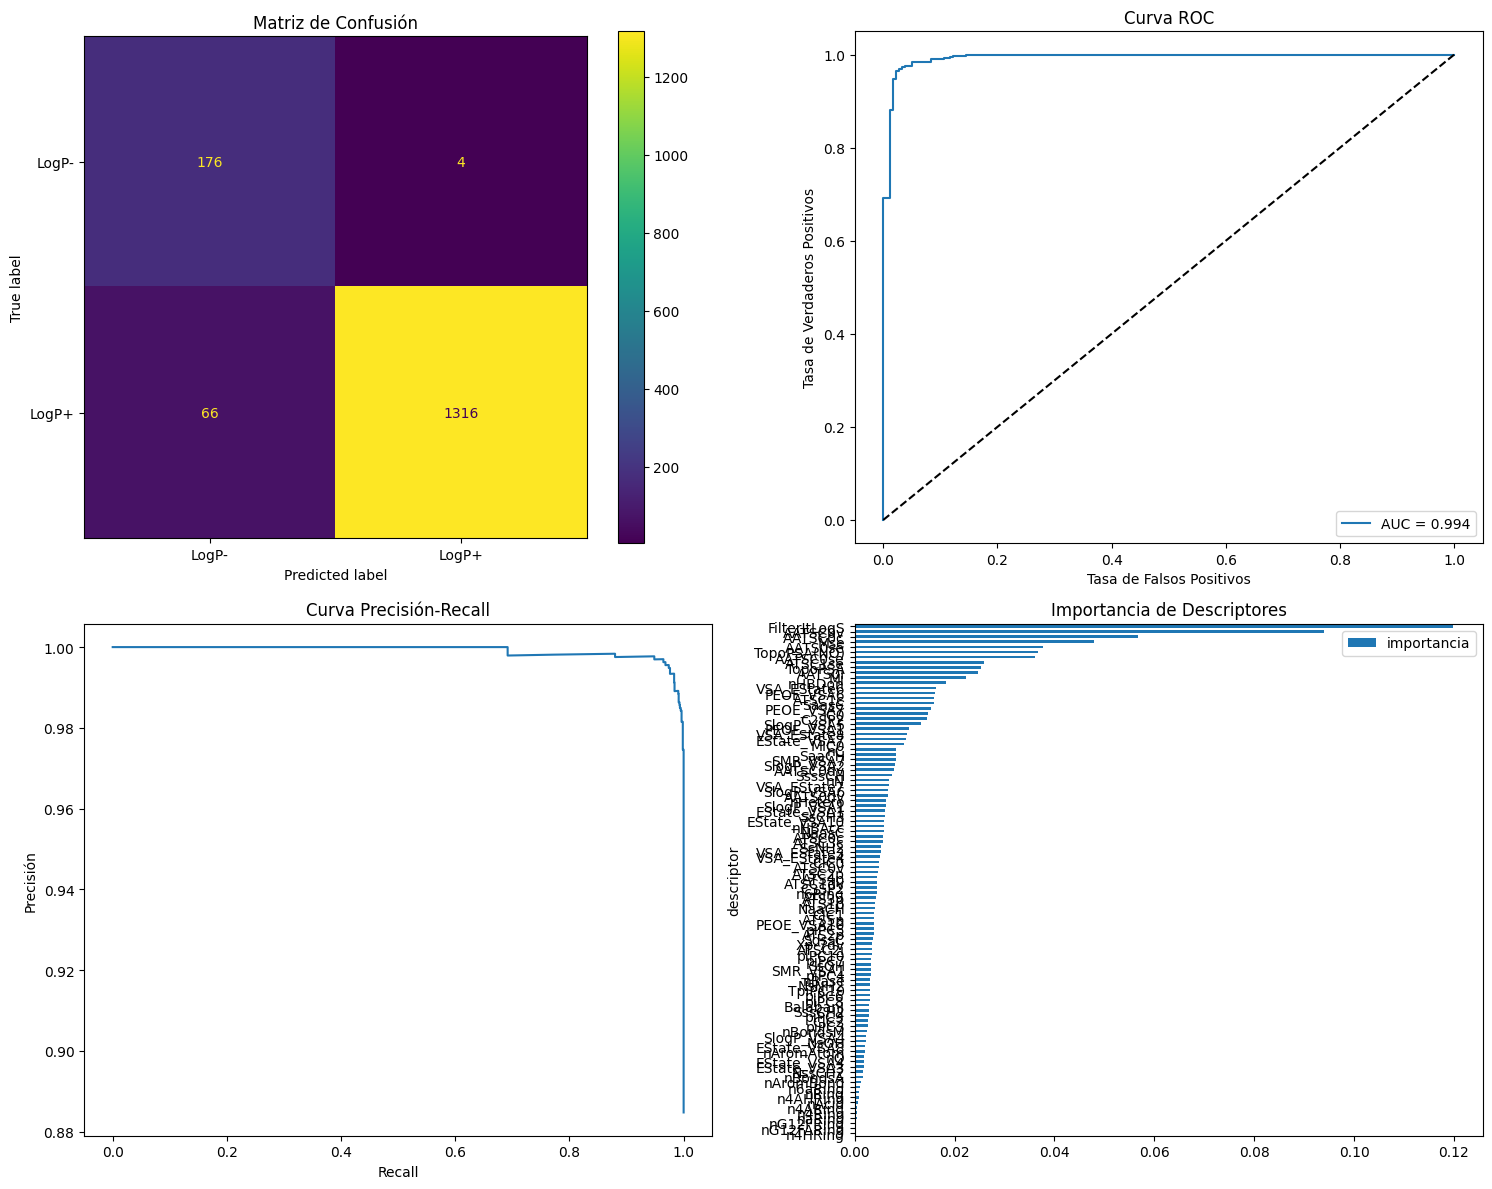

In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, confusion_matrix, ConfusionMatrixDisplay, 
                           classification_report, roc_curve, precision_recall_curve, 
                           auc, roc_auc_score)
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler
from scipy.stats import randint, uniform

# Cargar datos
file_path = r'C:\Users\USUARIO\Desktop\nuevo\BDFINAL.csv'
df = pd.read_csv(file_path, low_memory=False)

class PreparacionBHE:
    def __init__(self, df):
        # Seleccionar solo variables numéricas excepto LogP
        self.target = df['LogP']
        self.df = df.select_dtypes(include=[np.number]).drop(columns=['LogP'])
        self.scaler = StandardScaler()
        print(f"Total de variables predictoras numéricas: {len(self.df.columns)}")
        
        # Eliminar columnas con valores nulos
        self.df = self.df.dropna(axis=1)
        print(f"Variables predictoras después de eliminar columnas con nulos: {len(self.df.columns)}")
    
    def seleccionar_descriptores_relevantes(self, k=100):
        selector = SelectKBest(score_func=f_regression, k=k)
        selector.fit(self.df, self.target)
        
        return self.df.columns[selector.get_support()].tolist()
    
    def preparar_datos_modelo(self):
        descriptores = self.seleccionar_descriptores_relevantes()
        
        X = self.df[descriptores]
        y = self.target
        
        X_scaled = self.scaler.fit_transform(X)
        X_scaled = pd.DataFrame(X_scaled, columns=descriptores)
        
        # Usar umbral 0 para clasificación
        y_clases = (y > 0).astype(int)
        
        print("\nDistribución original de clases:")
        print(pd.Series(y_clases).value_counts(normalize=True).round(3) * 100, "%")
        
        # Dividir datos
        X_train, X_test, y_train, y_test = train_test_split(
            X_scaled, y_clases, test_size=0.2, random_state=42, stratify=y_clases
        )
        
        # Aplicar Random Undersampling
        rus = RandomUnderSampler(random_state=42)
        X_train_bal, y_train_bal = rus.fit_resample(X_train, y_train)
        
        print("\nDistribución después de Random Undersampling:")
        print(pd.Series(y_train_bal).value_counts(normalize=True).round(3) * 100, "%")
        
        return X_train_bal, X_test, y_train_bal, y_test, descriptores
    
    def optimizar_hiperparametros(self, X_train, y_train):
        param_distributions = {
            'n_estimators': randint(100, 1000),
            'max_depth': [None] + list(range(10, 110, 10)),
            'min_samples_split': randint(2, 20),
            'min_samples_leaf': randint(1, 10),
            'max_features': ['sqrt', 'log2', None],
            'bootstrap': [True, False],
            'criterion': ['gini', 'entropy'],
            'class_weight': ['balanced', 'balanced_subsample']
        }
        
        rf = RandomForestClassifier(random_state=42)
        
        random_search = RandomizedSearchCV(
            estimator=rf,
            param_distributions=param_distributions,
            n_iter=100,
            scoring='f1',
            cv=5,
            verbose=1,
            n_jobs=-1,
            random_state=42
        )
        
        print("\nOptimizando hiperparámetros usando RandomizedSearchCV...")
        print(f"Probando 100 combinaciones diferentes con 5-fold CV")
        
        random_search.fit(X_train, y_train)
        
        print("\nMejores parámetros encontrados:")
        for param, value in random_search.best_params_.items():
            print(f"{param}: {value}")
        
        print(f"\nMejor puntuación F1: {random_search.best_score_:.3f}")
        
        return random_search.best_estimator_
    
    def plot_curvas_evaluacion(self, y_test, y_pred, y_prob, titulo=""):
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
        
        # Matriz de confusión
        cm = confusion_matrix(y_test, y_pred)
        ConfusionMatrixDisplay(
            confusion_matrix=cm, 
            display_labels=['LogP-', 'LogP+']
        ).plot(ax=ax1)
        ax1.set_title('Matriz de Confusión')
        
        # Curva ROC
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        ax2.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
        ax2.plot([0, 1], [0, 1], 'k--')
        ax2.set_xlabel('Tasa de Falsos Positivos')
        ax2.set_ylabel('Tasa de Verdaderos Positivos')
        ax2.set_title('Curva ROC')
        ax2.legend()
        
        # Curva Precisión-Recall
        precision, recall, _ = precision_recall_curve(y_test, y_prob)
        ax3.plot(recall, precision)
        ax3.set_xlabel('Recall')
        ax3.set_ylabel('Precisión')
        ax3.set_title('Curva Precisión-Recall')
        
        # Importancia de características
        importancia = pd.DataFrame({
            'descriptor': self.current_descriptors,
            'importancia': self.current_model.feature_importances_
        }).sort_values('importancia', ascending=True)
        
        importancia.plot(kind='barh', x='descriptor', y='importancia', ax=ax4)
        ax4.set_title('Importancia de Descriptores')
        
        plt.tight_layout()
        plt.show()
    
    def entrenar_modelo(self):
        X_train, X_test, y_train, y_test, descriptores = self.preparar_datos_modelo()
        
        # Optimizar hiperparámetros
        modelo = self.optimizar_hiperparametros(X_train, y_train)
        
        # Entrenar modelo con mejores parámetros
        modelo.fit(X_train, y_train)
        
        # Guardar para visualización
        self.current_model = modelo
        self.current_descriptors = descriptores
        
        # Predicciones
        y_pred = modelo.predict(X_test)
        y_prob = modelo.predict_proba(X_test)[:, 1]
        
        # Métricas
        accuracy = accuracy_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_prob)
        
        print("\nResultados del modelo:")
        print("-" * 50)
        print(f"Accuracy: {accuracy:.3f}")
        print(f"ROC AUC: {roc_auc:.3f}")
        print("\nReporte de clasificación:")
        print(classification_report(y_test, y_pred))
        
        # Visualizar resultados
        self.plot_curvas_evaluacion(y_test, y_pred, y_prob)
        
        return modelo, (X_test, y_test, y_pred, y_prob)

# Ejecutar análisis
modelo_bhe = PreparacionBHE(df)
modelo, resultados = modelo_bhe.entrenar_modelo()


Umbral logBB seleccionado: -1
Valores logBB > -1 se clasifican como BBB+
Valores logBB ≤ -1 se clasifican como BBB-

Distribución de valores logBB:
Mínimo: -2.690
Máximo: 1.700
Media: -0.078
Mediana: -0.020

Distribución de clases:
BBB- (clase 0): 147 moléculas
BBB+ (clase 1): 911 moléculas

Porcentajes:
logBB
1    86.1
0    13.9
Name: proportion, dtype: float64 %


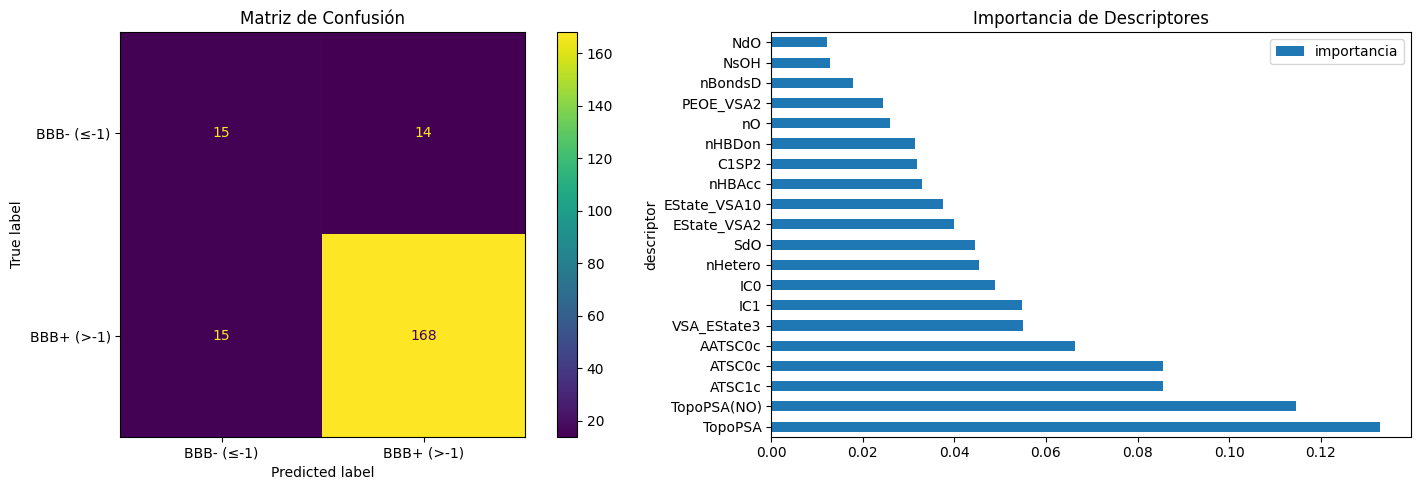


Precisión del modelo: 0.863

Descriptores más importantes:
      descriptor  importancia
19       TopoPSA     0.133041
18   TopoPSA(NO)     0.114590
3         ATSC1c     0.085627
2         ATSC0c     0.085567
4        AATSC0c     0.066433
17   VSA_EState3     0.055057
13           IC1     0.054701
12           IC0     0.048795
0        nHetero     0.045350
9            SdO     0.044403
15   EState_VSA2     0.039857
16  EState_VSA10     0.037419
10        nHBAcc     0.032918
6          C1SP2     0.031826
11        nHBDon     0.031391
1             nO     0.025946
14     PEOE_VSA2     0.024365
5        nBondsD     0.017817
7           NsOH     0.012824
8            NdO     0.012073


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Ruta al archivo CSV
file_path = r'C:\Users\USUARIO\Desktop\nuevo\BDFINAL.csv'

# Cargar el archivo CSV en un DataFrame
df = pd.read_csv(file_path, low_memory=False)

class PreparacionBHE:
    def __init__(self, df, umbral_logbb=-1):  # Añadimos el parámetro umbral_logbb
        self.df = df.select_dtypes(include=[np.number])
        self.scaler = StandardScaler()
        self.umbral_logbb = umbral_logbb  # Guardamos el umbral como atributo de la clase
        print(f"\nUmbral logBB seleccionado: {self.umbral_logbb}")
        print("Valores logBB > {} se clasifican como BBB+".format(self.umbral_logbb))
        print("Valores logBB ≤ {} se clasifican como BBB-".format(self.umbral_logbb))
    
    def seleccionar_descriptores_relevantes(self, k=20):
        if 'logBB' not in self.df.columns:
            raise ValueError("'logBB' no está en el DataFrame.")
        
        X = self.df.drop(columns='logBB', errors='ignore')
        y = self.df['logBB'].dropna()
        X = X.loc[y.index]
        
        selector = SelectKBest(score_func=f_regression, k=k)
        selector.fit(X, y)
        
        return X.columns[selector.get_support()].tolist()
    
    def preparar_datos_modelo(self):
        descriptores = self.seleccionar_descriptores_relevantes()
        
        X = self.df[descriptores]
        y = self.df['logBB']
        
        datos_completos = pd.concat([X, y], axis=1).dropna()
        X = datos_completos[descriptores]
        y = datos_completos['logBB']
        
        X_scaled = self.scaler.fit_transform(X)
        X_scaled = pd.DataFrame(X_scaled, columns=descriptores)
        
        # Clasificación explícita usando el umbral definido
        y_clases = (y > self.umbral_logbb).astype(int)
        
        # Mostrar distribución de clases y valores
        print("\nDistribución de valores logBB:")
        print(f"Mínimo: {y.min():.3f}")
        print(f"Máximo: {y.max():.3f}")
        print(f"Media: {y.mean():.3f}")
        print(f"Mediana: {y.median():.3f}")
        
        print("\nDistribución de clases:")
        clase_counts = y_clases.value_counts()
        print(f"BBB- (clase 0): {clase_counts[0]} moléculas")
        print(f"BBB+ (clase 1): {clase_counts[1]} moléculas")
        print("\nPorcentajes:")
        print(y_clases.value_counts(normalize=True).round(3) * 100, "%")
        
        X_train, X_test, y_train, y_test = train_test_split(
            X_scaled, y_clases, test_size=0.2, random_state=42, stratify=y_clases
        )
        
        return X_train, X_test, y_train, y_test, descriptores
    
    def entrenar_modelo(self):
        X_train, X_test, y_train, y_test, descriptores = self.preparar_datos_modelo()
        
        modelo = RandomForestClassifier(
            n_estimators=100,
            max_depth=10,
            min_samples_split=5,
            random_state=42,
            class_weight='balanced'
        )
        
        modelo.fit(X_train, y_train)
        
        y_pred = modelo.predict(X_test)
        
        accuracy = accuracy_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)
        
        importancia = pd.DataFrame({
            'descriptor': descriptores,
            'importancia': modelo.feature_importances_
        }).sort_values('importancia', ascending=False)
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Etiquetas más explícitas para la matriz de confusión
        ConfusionMatrixDisplay(
            confusion_matrix=cm, 
            display_labels=['BBB- (≤{})'.format(self.umbral_logbb), 
                          'BBB+ (>{})'.format(self.umbral_logbb)]
        ).plot(ax=ax1)
        ax1.set_title('Matriz de Confusión')
        
        importancia.plot(kind='barh', x='descriptor', y='importancia', ax=ax2)
        ax2.set_title('Importancia de Descriptores')
        
        plt.tight_layout()
        plt.show()
        
        print(f"\nPrecisión del modelo: {accuracy:.3f}")
        print("\nDescriptores más importantes:")
        print(importancia)
        
        return modelo, importancia, (X_test, y_test, y_pred)

# Crear una instancia de la clase con umbral específico
modelo_bhe = PreparacionBHE(df, umbral_logbb=-1)  

# Entrenar el modelo y obtener resultados
modelo, importancia, resultados = modelo_bhe.entrenar_modelo()


Entrenando modelo con método: none
Total de variables numéricas: 616

Distribución original de clases:
logBB
0    53.0
1    47.0
Name: proportion, dtype: float64 %


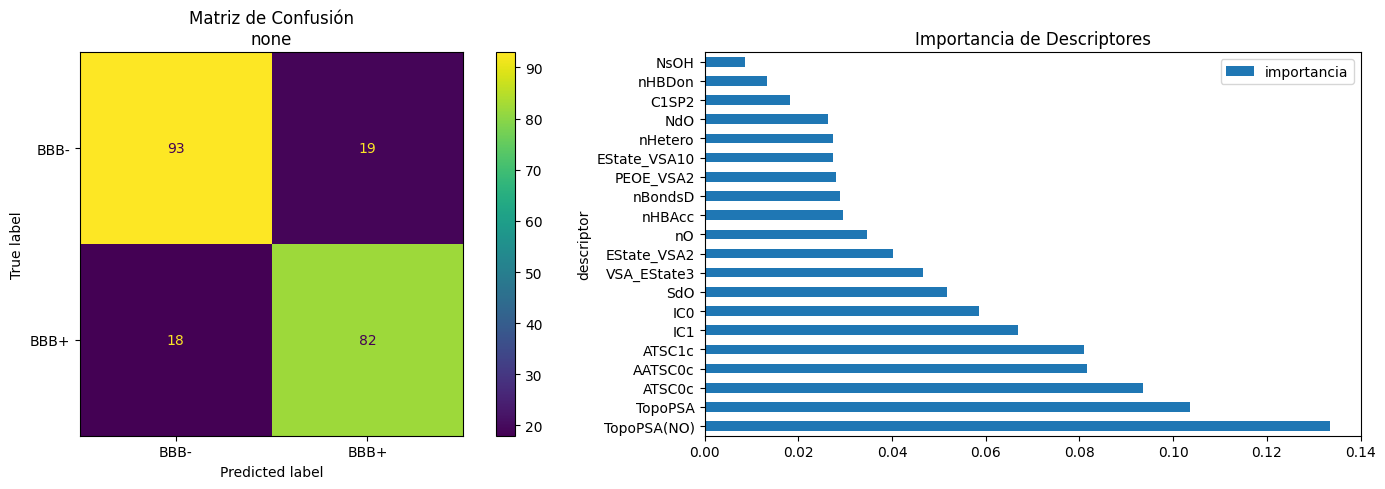


Resultados con none:
--------------------------------------------------
Precisión del modelo: 0.825

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.84      0.83      0.83       112
           1       0.81      0.82      0.82       100

    accuracy                           0.83       212
   macro avg       0.82      0.83      0.83       212
weighted avg       0.83      0.83      0.83       212


Entrenando modelo con método: random_under
Total de variables numéricas: 616

Distribución original de clases:
logBB
0    53.0
1    47.0
Name: proportion, dtype: float64 %

Distribución después de Random Undersampling:
logBB
0    50.0
1    50.0
Name: proportion, dtype: float64 %


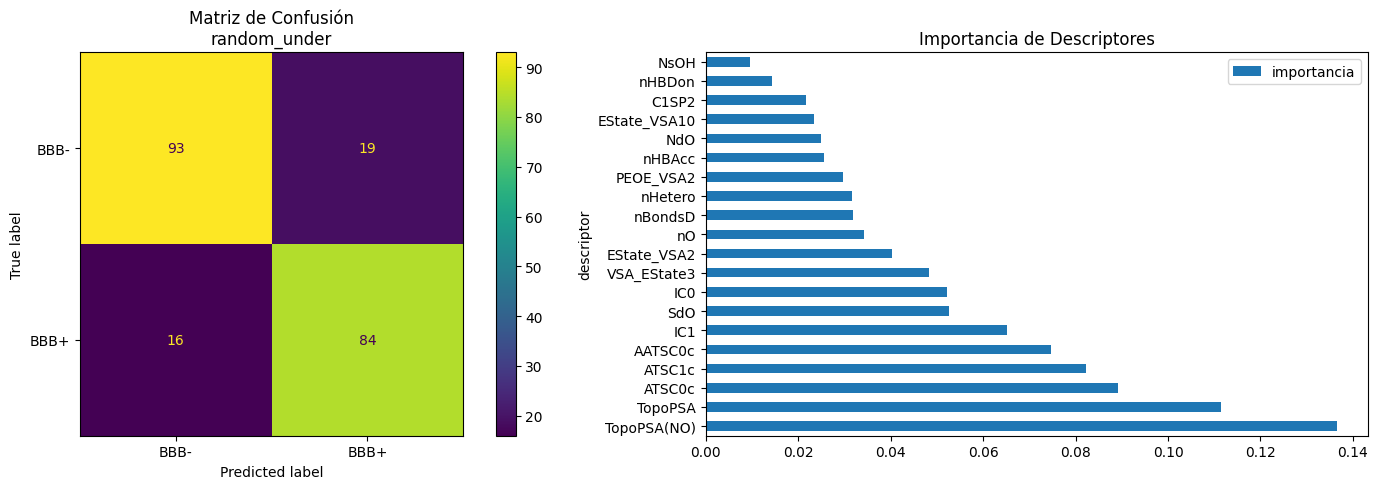


Resultados con random_under:
--------------------------------------------------
Precisión del modelo: 0.835

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.85      0.83      0.84       112
           1       0.82      0.84      0.83       100

    accuracy                           0.83       212
   macro avg       0.83      0.84      0.83       212
weighted avg       0.84      0.83      0.84       212


Entrenando modelo con método: nearmiss
Total de variables numéricas: 616

Distribución original de clases:
logBB
0    53.0
1    47.0
Name: proportion, dtype: float64 %

Distribución después de NearMiss:
logBB
0    50.0
1    50.0
Name: proportion, dtype: float64 %


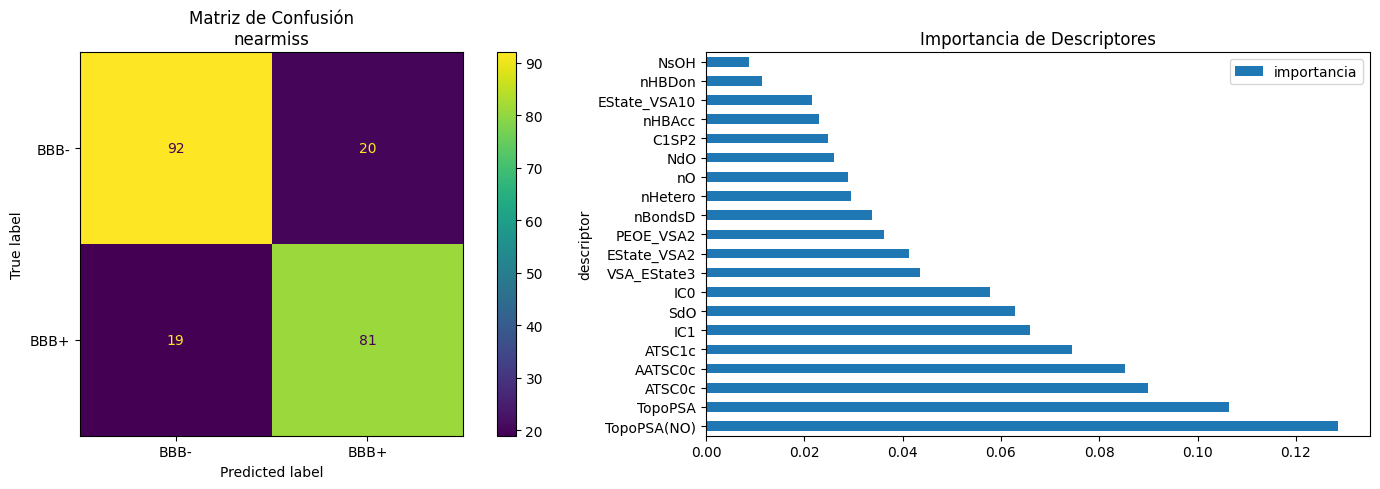


Resultados con nearmiss:
--------------------------------------------------
Precisión del modelo: 0.816

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.83      0.82      0.83       112
           1       0.80      0.81      0.81       100

    accuracy                           0.82       212
   macro avg       0.82      0.82      0.82       212
weighted avg       0.82      0.82      0.82       212



In [35]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler, NearMiss

# Cargar datos
file_path = r'C:\Users\USUARIO\Desktop\nuevo\BDFINAL.csv'
df = pd.read_csv(file_path, low_memory=False)

class PreparacionBHE:
    def __init__(self, df):
        self.df = df.select_dtypes(include=[np.number])
        self.scaler = StandardScaler()
        print(f"Total de variables numéricas: {len(self.df.columns)}")
    
    def seleccionar_descriptores_relevantes(self, k=20):
        if 'logBB' not in self.df.columns:
            raise ValueError("'logBB' no está en el DataFrame.")
        
        X = self.df.drop(columns='logBB', errors='ignore')
        y = self.df['logBB'].dropna()
        X = X.loc[y.index]
        
        selector = SelectKBest(score_func=f_regression, k=k)
        selector.fit(X, y)
        
        return X.columns[selector.get_support()].tolist()
    
    def preparar_datos_modelo(self, metodo_balance='none'):
        descriptores = self.seleccionar_descriptores_relevantes()
        
        X = self.df[descriptores]
        y = self.df['logBB']
        
        datos_completos = pd.concat([X, y], axis=1).dropna()
        X = datos_completos[descriptores]
        y = datos_completos['logBB']
        
        X_scaled = self.scaler.fit_transform(X)
        X_scaled = pd.DataFrame(X_scaled, columns=descriptores)
        
        # Usar umbral 0 para clasificación
        y_clases = (y > 0).astype(int)
        
        print("\nDistribución original de clases:")
        print(pd.Series(y_clases).value_counts(normalize=True).round(3) * 100, "%")
        
        # Dividir datos
        X_train, X_test, y_train, y_test = train_test_split(
            X_scaled, y_clases, test_size=0.2, random_state=42, stratify=y_clases
        )
        
        # Aplicar técnica de balanceo seleccionada
        if metodo_balance == 'random_under':
            rus = RandomUnderSampler(random_state=42)
            X_train_bal, y_train_bal = rus.fit_resample(X_train, y_train)
            print("\nDistribución después de Random Undersampling:")
            print(pd.Series(y_train_bal).value_counts(normalize=True).round(3) * 100, "%")
            return X_train_bal, X_test, y_train_bal, y_test, descriptores
            
        elif metodo_balance == 'nearmiss':
            nm = NearMiss()
            X_train_bal, y_train_bal = nm.fit_resample(X_train, y_train)
            print("\nDistribución después de NearMiss:")
            print(pd.Series(y_train_bal).value_counts(normalize=True).round(3) * 100, "%")
            return X_train_bal, X_test, y_train_bal, y_test, descriptores
        
        return X_train, X_test, y_train, y_test, descriptores
    
    def entrenar_modelo(self, metodo_balance='none'):
        X_train, X_test, y_train, y_test, descriptores = self.preparar_datos_modelo(metodo_balance)
        
        # Configurar modelo
        if metodo_balance == 'none':
            modelo = RandomForestClassifier(
                n_estimators=100,
                max_depth=10,
                min_samples_split=5,
                random_state=42,
                class_weight='balanced'  # Usar pesos balanceados si no se usa otra técnica
            )
        else:
            modelo = RandomForestClassifier(
                n_estimators=100,
                max_depth=10,
                min_samples_split=5,
                random_state=42
            )
        
        # Entrenar modelo
        modelo.fit(X_train, y_train)
        
        # Predicciones
        y_pred = modelo.predict(X_test)
        
        # Métricas
        accuracy = accuracy_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)
        
        # Visualización
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Matriz de confusión
        ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['BBB-', 'BBB+']).plot(ax=ax1)
        ax1.set_title(f'Matriz de Confusión\n{metodo_balance}')
        
        # Importancia de características
        importancia = pd.DataFrame({
            'descriptor': descriptores,
            'importancia': modelo.feature_importances_
        }).sort_values('importancia', ascending=False)
        
        importancia.plot(kind='barh', x='descriptor', y='importancia', ax=ax2)
        ax2.set_title('Importancia de Descriptores')
        
        plt.tight_layout()
        plt.show()
        
        print(f"\nResultados con {metodo_balance}:")
        print("-" * 50)
        print(f"Precisión del modelo: {accuracy:.3f}")
        print("\nReporte de clasificación:")
        print(classification_report(y_test, y_pred))
        
        return modelo, importancia, (X_test, y_test, y_pred)

# Probar diferentes métodos de balanceo
metodos = ['none', 'random_under', 'nearmiss']

for metodo in metodos:
    print(f"\n{'='*50}")
    print(f"Entrenando modelo con método: {metodo}")
    print(f"{'='*50}")
    
    modelo_bhe = PreparacionBHE(df)
    modelo, importancia, resultados = modelo_bhe.entrenar_modelo(metodo)

## Modelo Utilizado Random Forest Classifier

En el presente estudio se emplea un Random Forest Classifier, un algoritmo de aprendizaje automático supervisado que se destaca por su capacidad para abordar problemas de clasificación y regresión. Este enfoque se fundamenta en la construcción de múltiples árboles de decisión durante la fase de entrenamiento, donde cada árbol realiza predicciones basadas en subconjuntos aleatorios de datos y características. La predicción final se determina mediante un voto mayoritario entre los árboles, lo que contribuye a mejorar la precisión del modelo y a mitigar el riesgo de sobreajuste, un desafío común en los árboles de decisión individuales.
Variable Objetivo
La variable objetivo del modelo es logBB, que representa la probabilidad de que una molécula atraviese la barrera hematoencefálica (BHE). El modelo utiliza descriptores químicos como variables predictivas para estimar esta probabilidad, facilitando así la identificación de compuestos potencialmente efectivos en tratamientos médicos. Este enfoque permite una evaluación más precisa de las propiedades farmacológicas de las moléculas en estudio.

Descriptores seleccionados: ['nHetero', 'nO', 'ATSC0c', 'ATSC1c', 'AATSC0c', 'nBondsD', 'C1SP2', 'NsOH', 'NdO', 'SdO', 'nHBAcc', 'nHBDon', 'IC0', 'IC1', 'PEOE_VSA2', 'EState_VSA2', 'EState_VSA10', 'VSA_EState3', 'TopoPSA(NO)', 'TopoPSA']
Precisión del modelo: 0.9871959026888605
Número de moléculas que atraviesan la BHE: 849
Número de moléculas que NO atraviesan la BHE: 713


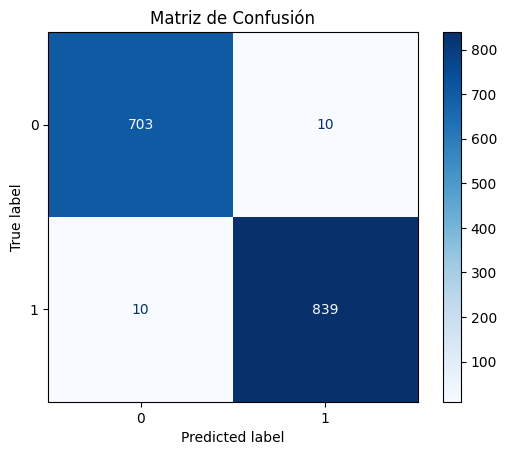

<Figure size 600x400 with 0 Axes>

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Ruta al archivo CSV
file_path = r'C:\Users\USUARIO\Desktop\nuevo\BDFINAL.csv'

# Cargar el archivo CSV en un DataFrame
df = pd.read_csv(file_path, low_memory=False)

class PreparacionBHE:
    def __init__(self, df):
        self.df = df.select_dtypes(include=[np.number])  # Seleccionar solo columnas numéricas
        self.scaler = StandardScaler()
    
    def seleccionar_descriptores_relevantes(self, k=20):
        # Asegurarse de que 'logBB' esté en el DataFrame
        if 'logBB' not in self.df.columns:
            raise ValueError("'logBB' no está en el DataFrame.")
        
        # Usar todos los descriptores numéricos, excepto 'logBB'
        X = self.df.drop(columns='logBB', errors='ignore')  
        y = self.df['logBB'].dropna()  
        
        # Asegurarse de que X esté alineado con y después de eliminar nulos
        X = X.loc[y.index]
        
        selector = SelectKBest(score_func=f_regression, k=k)
        selector.fit(X, y)
        
        descriptores_seleccionados = X.columns[selector.get_support()].tolist()
        
        return descriptores_seleccionados
    
    def calcular_probabilidad_bhe(self, descriptores):
        X = self.df[descriptores].dropna()  # Omitir nulos en los descriptores
        
        # Normalizar los datos
        X_scaled = self.scaler.fit_transform(X)
        
        # Definir los umbrales para cada descriptor (estos son ejemplos y deben ajustarse)
        umbrales = {
            'LogP': 2.0,
            'nHBAcc': 3,
            'nHBDon': 2,
            'MW': 400,
            'TopoPSA': 90,
            'nRotB': 5,
            'LabuteASA': 300,
        }
        
        # Calcular la probabilidad de atravesar la BHE
        probabilidades = []
        for _, row in X.iterrows():
            condiciones_cumplidas = 0
            for desc in descriptores:
                if desc in umbrales:
                    if desc == 'LogP':
                        condiciones_cumplidas += 1 if row[desc] >= umbrales[desc] else 0
                    else:
                        condiciones_cumplidas += 1 if row[desc] <= umbrales[desc] else 0
                else:
                    # Para descriptores sin umbral definido, asumimos que valores más bajos son mejores
                    condiciones_cumplidas += 1 if row[desc] <= X[desc].median() else 0
            
            prob = condiciones_cumplidas / len(descriptores)
            probabilidades.append(prob)
        
        return np.array(probabilidades)

    def preparar_datos_modelo(self):
        descriptores = self.seleccionar_descriptores_relevantes()
        
        # Calcular la probabilidad de atravesar la BHE
        y_prob = self.calcular_probabilidad_bhe(descriptores)
        
        # Convertir probabilidades a clases (0 o 1) usando un umbral (ej. 0.5)
        y_clases = (y_prob >= 0.5).astype(int)

        # Usar los descriptores seleccionados como variables predictoras
        X = self.df[descriptores].dropna()  # Omitir nulos en los descriptores

        # Asegurarse de que y_clases tenga el mismo tamaño que X
        y_clases = y_clases[:len(X)]  # Asegurarse de que las dimensiones coincidan

        # Dividir en conjuntos de entrenamiento y prueba
        X_train, X_test, y_train, y_test = train_test_split(X, y_clases, test_size=0.2, random_state=42)
        
        return X_train, X_test, y_train, y_test, descriptores

    def entrenar_modelo(self):
        X_train, X_test, y_train, y_test, descriptores = self.preparar_datos_modelo()
        
        # Entrenar un modelo de bosque aleatorio
        modelo = RandomForestClassifier(n_estimators=100, random_state=42)
        modelo.fit(X_train, y_train)
        
        # Predecir en el conjunto de prueba
        y_pred = modelo.predict(X_test)
        
        # Calcular métricas de evaluación
        accuracy = accuracy_score(y_test, y_pred)
        
        print("Descriptores seleccionados:", descriptores)
        print("Precisión del modelo:", accuracy)

        # Calcular cuántas moléculas atraviesan la BHE
        num_atravesando = (y_pred == 1).sum()
        num_no_atravesando = (y_pred == 0).sum()
        
        print("Número de moléculas que atraviesan la BHE:", num_atravesando)
        print("Número de moléculas que NO atraviesan la BHE:", num_no_atravesando)
        
        # Crear matriz de confusión
        cm = confusion_matrix(y_test, y_pred)
        
        # Mostrar matriz de confusión
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
        disp.plot(cmap='Blues', ax=plt.gca())
        plt.title('Matriz de Confusión')
        plt.figure(figsize=(6, 4))  # Ajustar el tamaño de la figura
        plt.show()
        
        return modelo, X_test, y_test, y_pred

# Crear una instancia de la clase
modelo_bhe = PreparacionBHE(df)

# Entrenar el modelo y obtener resultados
modelo, X_test, y_test, y_pred = modelo_bhe.entrenar_modelo()


El código presentado implementa un modelo de Random Forest Classifier para predecir la lipofilia de compuestos químicos mediante la variable objetivo LogP. Su propósito es clasificar las moléculas en función de su capacidad para tener un LogP mayor o igual a 2, lo que indica una mayor probabilidad de atravesar la barrera hematoencefálica. El proceso comienza con la carga de datos, seguido de la preparación de los mismos mediante la selección de características numéricas y el escalado de estas. Se aplica Random Under-Sampling para equilibrar las clases antes de dividir los datos en conjuntos de entrenamiento y prueba. Posteriormente, se optimizan los hiperparámetros del modelo utilizando RandomizedSearchCV, buscando mejorar la precisión del clasificador. Finalmente, el modelo se evalúa a través de métricas como la matriz de confusión, el reporte de clasificación y la curva ROC, además de visualizar las características más importantes que influyen en las predicciones, proporcionando así una comprensión integral del rendimiento del modelo.

📂 Cargando datos...
✅ Datos originales: 7807 moléculas

🔄 Preparando datos...

Distribución original de clases:
LogP
1   61.000
0   39.000
Name: proportion, dtype: float64

Distribución después de Random Under-Sampling:
LogP
0   50.000
1   50.000
Name: proportion, dtype: float64

🔍 Optimizando modelo...
Fitting 5 folds for each of 10 candidates, totalling 50 fits

Mejores parámetros encontrados:
n_estimators: 50
min_samples_split: 15
min_samples_leaf: 10
max_features: sqrt
max_depth: 4
class_weight: balanced
bootstrap: True

=== Reporte de Clasificación ===
              precision    recall  f1-score   support

           0       0.94      0.97      0.95       637
           1       0.96      0.93      0.95       582

    accuracy                           0.95      1219
   macro avg       0.95      0.95      0.95      1219
weighted avg       0.95      0.95      0.95      1219



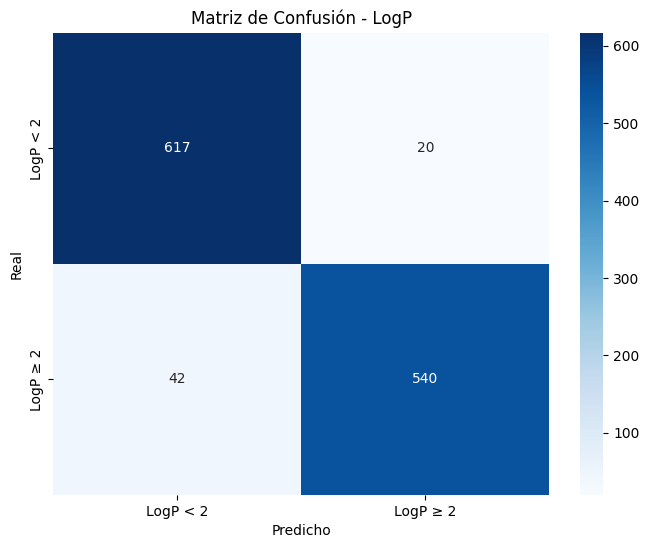

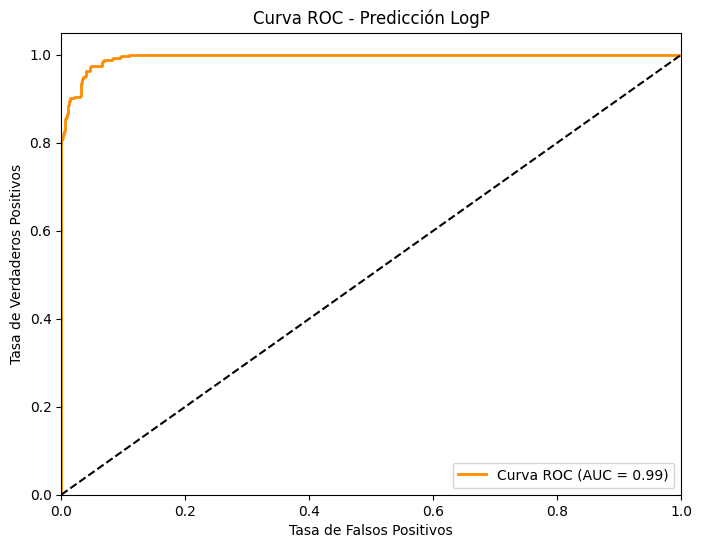

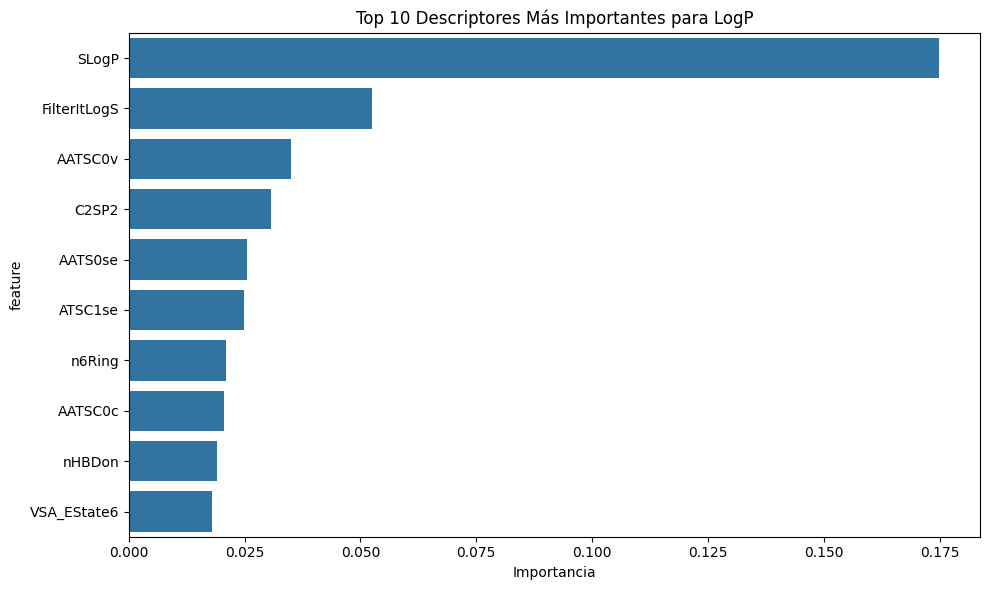


Top 10 descriptores más importantes:
SLogP: 0.1750
FilterItLogS: 0.0524
AATSC0v: 0.0351
C2SP2: 0.0307
AATS0se: 0.0256
ATSC1se: 0.0249
n6Ring: 0.0209
AATSC0c: 0.0205
nHBDon: 0.0191
VSA_EState6: 0.0179

✨ Modelo guardado como 'random_forest_logp.joblib'


In [29]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler
import warnings
warnings.filterwarnings('ignore')

# Cargar datos
print("📂 Cargando datos...")
try:
    df = pd.read_csv('BDFINAL.csv')
    print(f"✅ Datos originales: {len(df)} moléculas")
except Exception as e:
    print(f"❌ Error al cargar los datos: {str(e)}")
    raise

class ModeloLogP:
    def __init__(self, df):
        self.df = df
        self.scaler = StandardScaler()
        self.best_model = None
        
    def preparar_datos(self):
        """Preparar datos con Random Under-Sampling"""
        print("\n🔄 Preparando datos...")
        
        # Seleccionar características
        features = self.df.select_dtypes(include=['float64', 'int64']).columns
        features = features.drop('LogP')
        
        # Preparar X e y
        X = self.df[features]
        y = (self.df['LogP'] >= 2).astype(int)
        
        # Escalar características
        X_scaled = self.scaler.fit_transform(X)
        X_scaled = pd.DataFrame(X_scaled, columns=features)
        
        print("\nDistribución original de clases:")
        print(y.value_counts(normalize=True).round(3) * 100)
        
        # Aplicar Random Under-Sampling
        rus = RandomUnderSampler(random_state=42)
        X_balanced, y_balanced = rus.fit_resample(X_scaled, y)
        
        print("\nDistribución después de Random Under-Sampling:")
        print(pd.Series(y_balanced).value_counts(normalize=True).round(3) * 100)
        
        return train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

    def entrenar_modelo(self, X_train, y_train):
        """Entrenar Random Forest con parámetros conservadores"""
        print("\n🔍 Optimizando modelo...")
        
        param_dist = {
            'n_estimators': [30, 50, 70],
            'max_depth': [3, 4],
            'min_samples_split': [15, 20],
            'min_samples_leaf': [10, 15],
            'max_features': ['sqrt'],
            'bootstrap': [True],
            'class_weight': ['balanced']
        }
        
        rf = RandomForestClassifier(random_state=42)
        
        search = RandomizedSearchCV(
            rf, 
            param_dist, 
            n_iter=10,
            cv=5,
            scoring='balanced_accuracy',
            n_jobs=-1,
            verbose=1
        )
        
        search.fit(X_train, y_train)
        self.best_model = search.best_estimator_
        
        print("\nMejores parámetros encontrados:")
        for param, value in search.best_params_.items():
            print(f"{param}: {value}")
        
        return self.best_model

    def evaluar_modelo(self, X_test, y_test):
        """Evaluar modelo"""
        y_pred = self.best_model.predict(X_test)
        y_prob = self.best_model.predict_proba(X_test)[:, 1]
        
        print("\n=== Reporte de Clasificación ===")
        print(classification_report(y_test, y_pred))
        
        # Matriz de confusión
        plt.figure(figsize=(8, 6))
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=['LogP < 2', 'LogP ≥ 2'],
                   yticklabels=['LogP < 2', 'LogP ≥ 2'])
        plt.title('Matriz de Confusión - LogP')
        plt.ylabel('Real')
        plt.xlabel('Predicho')
        plt.show()
        
        # Curva ROC
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, 
                label=f'Curva ROC (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('Tasa de Falsos Positivos')
        plt.ylabel('Tasa de Verdaderos Positivos')
        plt.title('Curva ROC - Predicción LogP')
        plt.legend(loc="lower right")
        plt.show()
        
        # Top 10 características
        importances = pd.DataFrame({
            'feature': X_test.columns,
            'importance': self.best_model.feature_importances_
        }).sort_values('importance', ascending=False)
        
        plt.figure(figsize=(10, 6))
        sns.barplot(data=importances.head(10), x='importance', y='feature')
        plt.title('Top 10 Descriptores Más Importantes para LogP')
        plt.xlabel('Importancia')
        plt.tight_layout()
        plt.show()
        
        print("\nTop 10 descriptores más importantes:")
        for i, row in importances.head(10).iterrows():
            print(f"{row['feature']}: {row['importance']:.4f}")

def main():
    modelo = ModeloLogP(df)
    X_train, X_test, y_train, y_test = modelo.preparar_datos()
    modelo.entrenar_modelo(X_train, y_train)
    modelo.evaluar_modelo(X_test, y_test)
    
    joblib.dump(modelo.best_model, 'random_forest_logp.joblib')
    print("\n✨ Modelo guardado como 'random_forest_logp.joblib'")

if __name__ == "__main__":
    main()

Random Forest Classifier para predecir la capacidad de las moléculas de atravesar la barrera hematoencefálica (BHE), utilizando como variable objetivo el descriptor logBB. La ejecución comienza con la carga de un conjunto de datos desde un archivo CSV, seguido de la limpieza para eliminar las filas con valores nulos en la columna logBB. A continuación, se preparan los datos seleccionando las características relevantes y escalándolas para mejorar el rendimiento del modelo. Se aplica una división estratificada entre conjuntos de entrenamiento y prueba, asegurando que ambas clases estén representadas equitativamente. El modelo se entrena optimizando los hiperparámetros mediante RandomizedSearchCV, buscando maximizar la puntuación F1. Finalmente, se evalúa el rendimiento del modelo a través de métricas como la matriz de confusión y la curva ROC, además de visualizar las características más influyentes en las predicciones, lo que proporciona una visión clara del desempeño del modelo en la clasificación.

📂 Cargando datos...
✅ Datos originales: 7807 moléculas
✅ Datos con logBB: 1058 moléculas

🔄 Preparando datos...

Distribución de clases:
logBB
0   51.000
1   49.000
Name: proportion, dtype: float64

🔍 Optimizando modelo...

Mejores parámetros encontrados:
n_estimators: 100
min_samples_split: 10
min_samples_leaf: 4
max_depth: 6
class_weight: balanced

=== Reporte de Clasificación ===
              precision    recall  f1-score   support

           0       0.79      0.78      0.78       108
           1       0.77      0.78      0.78       104

    accuracy                           0.78       212
   macro avg       0.78      0.78      0.78       212
weighted avg       0.78      0.78      0.78       212



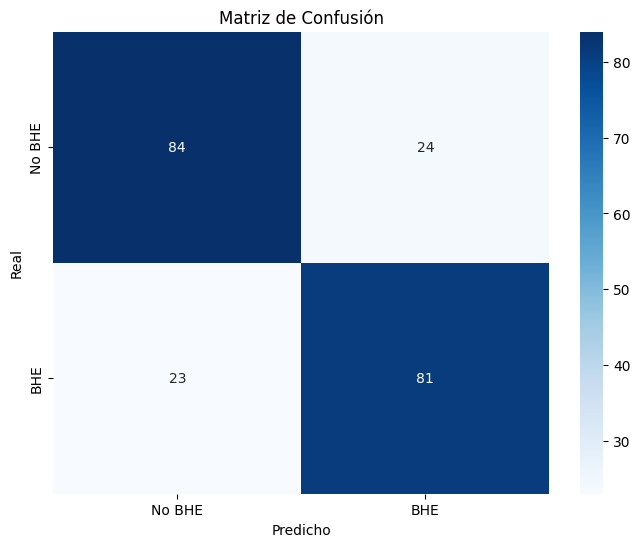

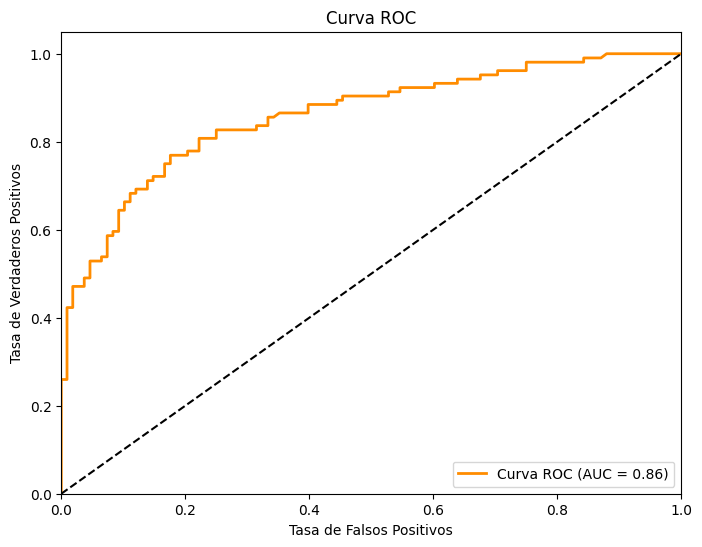

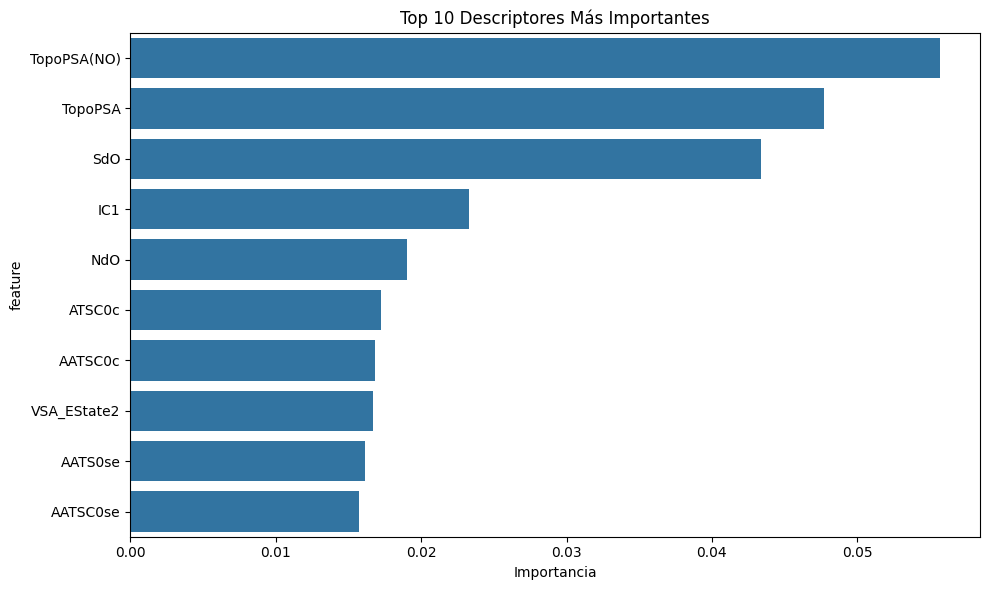


✨ Modelo guardado como 'random_forest_bhe.joblib'


In [25]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Cargar datos
print("📂 Cargando datos...")
try:
    df = pd.read_csv('BDFINAL.csv')
    # Filtrar solo las filas con logBB (eliminar nulos)
    df_clean = df.dropna(subset=['logBB'])
    print(f"✅ Datos originales: {len(df)} moléculas")
    print(f"✅ Datos con logBB: {len(df_clean)} moléculas")
except Exception as e:
    print(f"❌ Error al cargar los datos: {str(e)}")
    raise

class ModeloBHE:
    def __init__(self, df):
        self.df = df
        self.scaler = StandardScaler()
        self.best_model = None
        
    def preparar_datos(self):
        """Preparar datos solo con las moléculas que tienen logBB"""
        print("\n🔄 Preparando datos...")
        
        # Seleccionar características
        features = self.df.select_dtypes(include=['float64', 'int64']).columns
        features = features.drop('logBB')
        
        # Preparar X e y
        X = self.df[features]
        y = (self.df['logBB'] >= 0).astype(int)
        
        # Escalar características
        X_scaled = self.scaler.fit_transform(X)
        X_scaled = pd.DataFrame(X_scaled, columns=features)
        
        # Mostrar distribución de clases
        print("\nDistribución de clases:")
        print(y.value_counts(normalize=True).round(3) * 100)
        
        return train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

    def entrenar_modelo(self, X_train, y_train):
        """Entrenar Random Forest con optimización de hiperparámetros"""
        print("\n🔍 Optimizando modelo...")
        
        # Parámetros a probar
        param_dist = {
            'n_estimators': [50, 100, 150],
            'max_depth': [3, 4, 5, 6],
            'min_samples_split': [5, 10],
            'min_samples_leaf': [4, 8],
            'class_weight': ['balanced']
        }
        
        # Modelo base
        rf = RandomForestClassifier(random_state=42)
        
        # Búsqueda de mejores parámetros
        search = RandomizedSearchCV(
            rf, param_dist, n_iter=10, cv=5, scoring='f1', n_jobs=-1
        )
        
        search.fit(X_train, y_train)
        self.best_model = search.best_estimator_
        
        print("\nMejores parámetros encontrados:")
        for param, value in search.best_params_.items():
            print(f"{param}: {value}")
        
        return self.best_model

    def evaluar_modelo(self, X_test, y_test):
        """Evaluar modelo con métricas y visualizaciones"""
        # Predicciones
        y_pred = self.best_model.predict(X_test)
        y_prob = self.best_model.predict_proba(X_test)[:, 1]
        
        # Reporte de clasificación
        print("\n=== Reporte de Clasificación ===")
        print(classification_report(y_test, y_pred))
        
        # Matriz de confusión
        plt.figure(figsize=(8, 6))
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=['No BHE', 'BHE'],
                   yticklabels=['No BHE', 'BHE'])
        plt.title('Matriz de Confusión')
        plt.ylabel('Real')
        plt.xlabel('Predicho')
        plt.show()
        
        # Curva ROC
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, 
                label=f'Curva ROC (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('Tasa de Falsos Positivos')
        plt.ylabel('Tasa de Verdaderos Positivos')
        plt.title('Curva ROC')
        plt.legend(loc="lower right")
        plt.show()
        
        # Características más importantes
        importances = pd.DataFrame({
            'feature': X_test.columns,
            'importance': self.best_model.feature_importances_
        }).sort_values('importance', ascending=False)
        
        plt.figure(figsize=(10, 6))
        sns.barplot(data=importances.head(10), x='importance', y='feature')
        plt.title('Top 10 Descriptores Más Importantes')
        plt.xlabel('Importancia')
        plt.tight_layout()
        plt.show()

def main():
    # Crear y entrenar modelo
    modelo = ModeloBHE(df_clean)
    X_train, X_test, y_train, y_test = modelo.preparar_datos()
    modelo.entrenar_modelo(X_train, y_train)
    modelo.evaluar_modelo(X_test, y_test)
    
    # Guardar modelo
    import joblib
    joblib.dump(modelo.best_model, 'random_forest_bhe.joblib')
    print("\n✨ Modelo guardado como 'random_forest_bhe.joblib'")

if __name__ == "__main__":
    main()

El presente código implementa un modelo de Random Forest Classifier centrado en la predicción de la lipofilia de compuestos químicos mediante el descriptor LogP, a diferencia del código anterior, que se enfocaba en el descriptor logBB y su relación con la capacidad de atravesar la barrera hematoencefálica. En este análisis, se establece un umbral de clasificación para LogP en 2, mientras que el código previo utilizaba un umbral de 0 para logBB. Además, este código incorpora explícitamente la técnica de Random Under-Sampling para abordar el desbalance entre las clases, lo cual no se menciona en el anterior. También se observan diferencias en los parámetros utilizados para la optimización del modelo, así como en los nombres de los archivos guardados al final del proceso; este código guarda el modelo como 'random_forest_logp.joblib', reflejando su enfoque específico en LogP, mientras que el anterior lo hacía como 'random_forest_bhe.joblib'. Estas diferencias subrayan las variaciones en los objetivos analíticos y las propiedades químicas evaluadas por cada modelo.


📂 Cargando datos...
✅ Datos originales: 7807 moléculas

🔄 Preparando datos...

Distribución original de clases:
LogP
1   61.000
0   39.000
Name: proportion, dtype: float64

Distribución después de Random Under-Sampling:
LogP
0   50.000
1   50.000
Name: proportion, dtype: float64

🔍 Optimizando modelo...
Fitting 5 folds for each of 10 candidates, totalling 50 fits

Mejores parámetros encontrados:
n_estimators: 70
min_samples_split: 15
min_samples_leaf: 10
max_features: sqrt
max_depth: 4
class_weight: balanced
bootstrap: True

=== Reporte de Clasificación ===
              precision    recall  f1-score   support

           0       0.92      0.97      0.94       637
           1       0.96      0.91      0.94       582

    accuracy                           0.94      1219
   macro avg       0.94      0.94      0.94      1219
weighted avg       0.94      0.94      0.94      1219



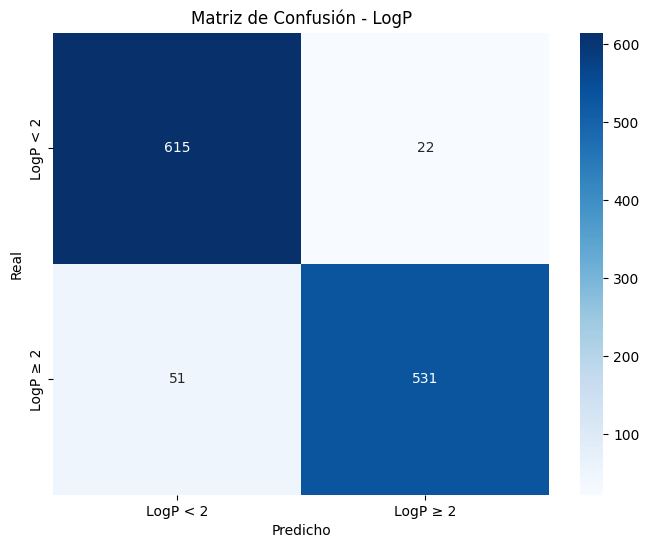

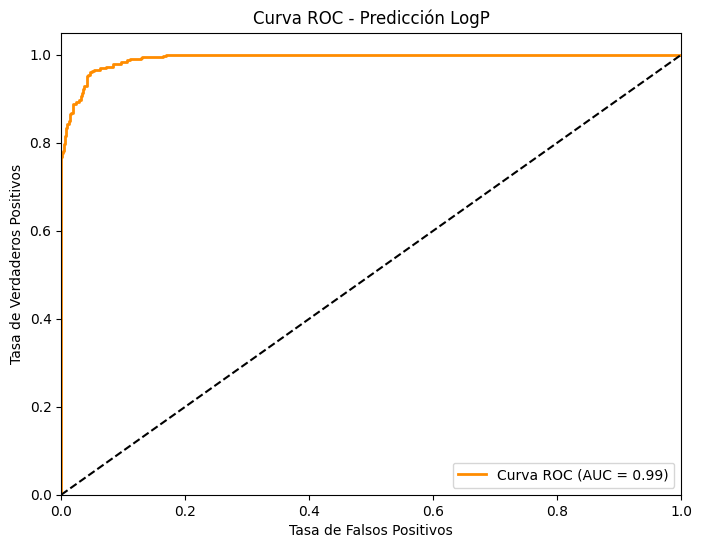

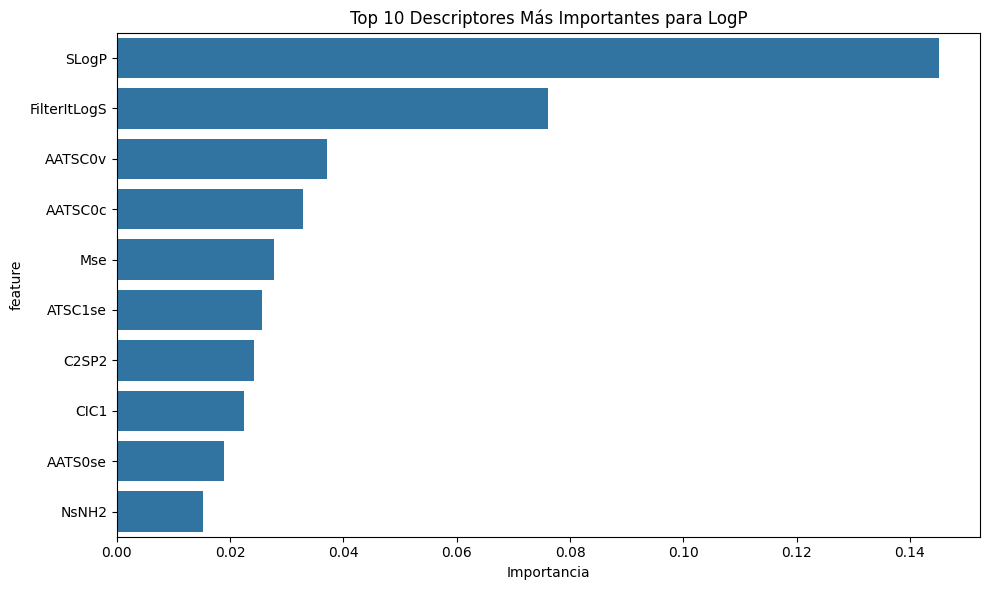


Top 10 descriptores más importantes:
SLogP: 0.1451
FilterItLogS: 0.0761
AATSC0v: 0.0371
AATSC0c: 0.0329
Mse: 0.0277
ATSC1se: 0.0256
C2SP2: 0.0242
CIC1: 0.0224
AATS0se: 0.0189
NsNH2: 0.0153

✨ Modelo guardado como 'random_forest_logp.joblib'


In [28]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler
import warnings
warnings.filterwarnings('ignore')

# Cargar datos
print("📂 Cargando datos...")
try:
    df = pd.read_csv('BDFINAL.csv')
    print(f"✅ Datos originales: {len(df)} moléculas")
except Exception as e:
    print(f"❌ Error al cargar los datos: {str(e)}")
    raise

class ModeloLogP:
    def __init__(self, df):
        self.df = df
        self.scaler = StandardScaler()
        self.best_model = None
        
    def preparar_datos(self):
        """Preparar datos con Random Under-Sampling"""
        print("\n🔄 Preparando datos...")
        
        # Seleccionar características
        features = self.df.select_dtypes(include=['float64', 'int64']).columns
        features = features.drop('LogP')
        
        # Preparar X e y
        X = self.df[features]
        y = (self.df['LogP'] >= 2).astype(int)
        
        # Escalar características
        X_scaled = self.scaler.fit_transform(X)
        X_scaled = pd.DataFrame(X_scaled, columns=features)
        
        print("\nDistribución original de clases:")
        print(y.value_counts(normalize=True).round(3) * 100)
        
        # Aplicar Random Under-Sampling
        rus = RandomUnderSampler(random_state=42)
        X_balanced, y_balanced = rus.fit_resample(X_scaled, y)
        
        print("\nDistribución después de Random Under-Sampling:")
        print(pd.Series(y_balanced).value_counts(normalize=True).round(3) * 100)
        
        return train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

    def entrenar_modelo(self, X_train, y_train):
        """Entrenar Random Forest con parámetros conservadores"""
        print("\n🔍 Optimizando modelo...")
        
        param_dist = {
            'n_estimators': [30, 50, 70],
            'max_depth': [3, 4],
            'min_samples_split': [15, 20],
            'min_samples_leaf': [10, 15],
            'max_features': ['sqrt'],
            'bootstrap': [True],
            'class_weight': ['balanced']
        }
        
        rf = RandomForestClassifier(random_state=42)
        
        search = RandomizedSearchCV(
            rf, 
            param_dist, 
            n_iter=10,
            cv=5,
            scoring='balanced_accuracy',
            n_jobs=-1,
            verbose=1
        )
        
        search.fit(X_train, y_train)
        self.best_model = search.best_estimator_
        
        print("\nMejores parámetros encontrados:")
        for param, value in search.best_params_.items():
            print(f"{param}: {value}")
        
        return self.best_model

    def evaluar_modelo(self, X_test, y_test):
        """Evaluar modelo"""
        y_pred = self.best_model.predict(X_test)
        y_prob = self.best_model.predict_proba(X_test)[:, 1]
        
        print("\n=== Reporte de Clasificación ===")
        print(classification_report(y_test, y_pred))
        
        # Matriz de confusión
        plt.figure(figsize=(8, 6))
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=['LogP < 2', 'LogP ≥ 2'],
                   yticklabels=['LogP < 2', 'LogP ≥ 2'])
        plt.title('Matriz de Confusión - LogP')
        plt.ylabel('Real')
        plt.xlabel('Predicho')
        plt.show()
        
        # Curva ROC
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, 
                label=f'Curva ROC (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('Tasa de Falsos Positivos')
        plt.ylabel('Tasa de Verdaderos Positivos')
        plt.title('Curva ROC - Predicción LogP')
        plt.legend(loc="lower right")
        plt.show()
        
        # Top 10 características
        importances = pd.DataFrame({
            'feature': X_test.columns,
            'importance': self.best_model.feature_importances_
        }).sort_values('importance', ascending=False)
        
        plt.figure(figsize=(10, 6))
        sns.barplot(data=importances.head(10), x='importance', y='feature')
        plt.title('Top 10 Descriptores Más Importantes para LogP')
        plt.xlabel('Importancia')
        plt.tight_layout()
        plt.show()
        
        print("\nTop 10 descriptores más importantes:")
        for i, row in importances.head(10).iterrows():
            print(f"{row['feature']}: {row['importance']:.4f}")

def main():
    modelo = ModeloLogP(df)
    X_train, X_test, y_train, y_test = modelo.preparar_datos()
    modelo.entrenar_modelo(X_train, y_train)
    modelo.evaluar_modelo(X_test, y_test)
    
    joblib.dump(modelo.best_model, 'random_forest_logp.joblib')
    print("\n✨ Modelo guardado como 'random_forest_logp.joblib'")

if __name__ == "__main__":
    main()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors
import matplotlib.pyplot as plt
import seaborn as sns

# Carga y preprocesamiento de datos
file_path = r'C:\Users\USUARIO\Desktop\nuevo\BDFINAL.csv'
df = pd.read_csv(file_path, low_memory=False)

# Funciones de evaluación molecular
def evaluate_smiles_length(smiles):
    length = len(smiles)
    return 'BBB+' if length <= 59 else 'BBB-' if length > 85 else 'Indeterminado'

def evaluate_chirality(mol):
    return 'Quiral' if len(Chem.FindMolChiralCenters(mol, includeUnassigned=True)) > 0 else 'No Quiral'

def evaluate_polarity(mol):
    logp = Descriptors.MolLogP(mol)
    return 'BBB+' if -4.38 <= logp <= 10.06 else 'BBB-' if logp < -8.90 or logp > 12.61 else 'Indeterminado'

def lipinski_rule(mol):
    mw = Descriptors.ExactMolWt(mol)
    logp = Descriptors.MolLogP(mol)
    hbd = Descriptors.NumHDonors(mol)
    hba = Descriptors.NumHAcceptors(mol)
    return sum([mw <= 500, logp <= 5, hbd <= 5, hba <= 10])

def classify_molecule(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None: return 'SMILES inválido'
    length_class = evaluate_smiles_length(smiles)
    polarity_class = evaluate_polarity(mol)
    lipinski_score = lipinski_rule(mol)
    if length_class == 'BBB+' and polarity_class == 'BBB+' and lipinski_score >= 3:
        return 'Alta probabilidad BBB+'
    elif length_class == 'BBB-' or polarity_class == 'BBB-' or lipinski_score < 2:
        return 'Alta probabilidad BBB-'
    else:
        return 'Indeterminado'

# Aplicación de clasificaciones
df['BBB_Class'] = df['SMILES'].apply(classify_molecule)
df['Chirality'] = df['SMILES'].apply(lambda x: evaluate_chirality(Chem.MolFromSmiles(x)))
df['SMILES_Length'] = df['SMILES'].apply(len)
df['Lipinski_Score'] = df['SMILES'].apply(lambda x: lipinski_rule(Chem.MolFromSmiles(x)))

# Filtrar solo las clases necesarias
df = df[df['BBB_Class'].isin(['Alta probabilidad BBB+', 'Alta probabilidad BBB-'])]

# Preparación de datos para CNN
def smiles_to_fingerprint(smiles, size=7806):
    mol = Chem.MolFromSmiles(smiles)
    return list(AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=size)) if mol else [0] * size

features = ['nHBAcc', 'nHBDon', 'MW', 'TopoPSA', 'LabuteASA', 'SMILES_Length', 'Lipinski_Score']
X_fp = np.array([smiles_to_fingerprint(smile) for smile in df['SMILES']])
X_features = df[features].values
X_combined = np.concatenate([X_fp, X_features], axis=1)

# Codificación de la variable objetivo
df['BBB_Class_Numeric'] = df['BBB_Class'].map({'Alta probabilidad BBB+': 0, 'Alta probabilidad BBB-': 1})
y = to_categorical(df['BBB_Class_Numeric'])

# División de datos
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# Escalado de características
scaler = StandardScaler()
X_train[:, -len(features):] = scaler.fit_transform(X_train[:, -len(features):])
X_test[:, -len(features):] = scaler.transform(X_test[:, -len(features):])

# Selección de características con RFE
selector = RandomForestClassifier(n_estimators=100, random_state=42)
rfe = RFE(selector, n_features_to_select=20)  
rfe.fit(X_train, np.argmax(y_train, axis=1))

# Obtener las variables seleccionadas
selected_features = np.array(features)[rfe.support_]
print(f'Número de variables analizadas: {len(selected_features)}')
print(f'Variables seleccionadas: {selected_features}')

# Redefinir los conjuntos de datos
X_train_selected = rfe.transform(X_train)
X_test_selected = rfe.transform(X_test)

# Reshape para CNN
X_train_selected = X_train_selected.reshape(X_train_selected.shape[0], X_train_selected.shape[1], 1)
X_test_selected = X_test_selected.reshape(X_test_selected.shape[0], X_test_selected.shape[1], 1)

# Definición del modelo CNN
def create_model(input_shape, filters=8, kernel_size=5, dense_units=16, dropout_rate=0.3, learning_rate=0.0005, l2_lambda=0.01):
    model = Sequential([
        Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', input_shape=input_shape, kernel_regularizer=l2(l2_lambda)),
        MaxPooling1D(pool_size=2),
        Dropout(dropout_rate),
        Conv1D(filters=filters*2, kernel_size=kernel_size, activation='relu', kernel_regularizer=l2(l2_lambda)),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(dense_units, activation='relu', kernel_regularizer=l2(l2_lambda)),
        Dropout(dropout_rate),
        Dense(2, activation='softmax')  # Cambiado a 2 para dos clases
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Implementación de validación cruzada
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

cv_scores = []
for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_selected), 1):
    print(f'Fold {fold}')
    X_train_fold, X_val_fold = X_train_selected[train_idx], X_train_selected[val_idx]
    y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]
    
    model = create_model(input_shape=(X_train_fold.shape[1], 1))
    
    history = model.fit(
        X_train_fold, y_train_fold,
        epochs=200, batch_size=64,
        validation_data=(X_val_fold, y_val_fold),
        callbacks=[early_stopping, reduce_lr],
        verbose=0
    )
    
    scores = model.evaluate(X_val_fold, y_val_fold, verbose=0)
    cv_scores.append(scores[1])
    print(f'Fold {fold} accuracy: {scores[1]:.4f}')

print(f'Mean CV accuracy: {np.mean(cv_scores):.4f} (+/- {np.std(cv_scores):.4f})')

# Entrenamiento del modelo final
final_model = create_model(input_shape=(X_train_selected.shape[1], 1))
final_history = final_model.fit(
    X_train_selected, y_train,
    epochs=200, batch_size=64, validation_split=0.01,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# Evaluación del modelo
test_loss, test_accuracy = final_model.evaluate(X_test_selected, y_test, verbose=0)
print(f'Test accuracy: {test_accuracy:.4f}')

y_pred = final_model.predict(X_test_selected)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Visualización de resultados
cm = confusion_matrix(y_test_classes, y_pred_classes)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['BBB+', 'BBB-'], yticklabels=['BBB+', 'BBB-'])
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.tight_layout()
plt.show()

print("\nInforme de Clasificación:")
print(classification_report(y_test_classes))
